## Lets predict the mobility of countries in times of COVID-19.
In recent years, mobility of each country has seen drastic changes due to COVID-19. Let us predict the factors that affect mobility the most. Every country have different variables (e.g. population density, vaccination rate). How can we group country that are similar together? By doing so, can we improve the prediction accuracy?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as plt
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

# 1. Data preparation
- Load CSV
- Drop irrelavant data (e.g. 'World' in continent, and 'tests_units' string column)
- Drop empty rows
- Merge COVID-19 data with mobility data

In [2]:
# Load data
general_data = pd.read_csv("owid-covid-data.csv")
mobility_data = pd.read_csv("changes-visitors-covid.csv")
print(general_data.shape, mobility_data.shape)

# Clean null columns in 'continent
# Data have non-country values under location (e.g. World, Asia)
# Remove 'tests_units' string column
general_data = general_data.dropna(subset=['continent'])
general_data = general_data.drop('tests_units', axis=1)
mobility_data = mobility_data.dropna()
print(general_data.shape, mobility_data.shape)

(169077, 67) (99336, 9)
(158965, 66) (96433, 9)


In [3]:
general_data_clean = general_data
general_data_clean.shape

(158965, 66)

In [4]:
mobility_data['Average'] = mobility_data[["retail_and_recreation", "parks", "grocery_and_pharmacy", "residential", "transit_stations", "workplaces"]].mean(axis=1)
mobility_data

Entity Code         Day  retail_and_recreation  \
0      Afghanistan  AFG  2020-02-17                  0.000   
1      Afghanistan  AFG  2020-02-18                  0.750   
2      Afghanistan  AFG  2020-02-19                  0.400   
3      Afghanistan  AFG  2020-02-20                  0.000   
4      Afghanistan  AFG  2020-02-21                  0.000   
...            ...  ...         ...                    ...   
99331     Zimbabwe  ZWE  2022-03-08                 94.571   
99332     Zimbabwe  ZWE  2022-03-09                 95.714   
99333     Zimbabwe  ZWE  2022-03-10                 96.286   
99334     Zimbabwe  ZWE  2022-03-11                 96.286   
99335     Zimbabwe  ZWE  2022-03-12                 96.000   

       grocery_and_pharmacy  residential  transit_stations    parks  \
0                     4.000        1.333             5.667    1.000   
1                     4.250        0.750             6.500    1.500   
2                     4.000        0.800             5.200    1.400   
3                     3.833        0.833             5.000    1.000   
4                     4.571        0.714             5.286    1.429   
...                     ...          ...               ...      ...   
99331               110.571        3.571           102.286  143.143   
99332               110.571        4.714           103.000  151.143   
99333               109.714        5.857           103.286  158.143   
99334               108.571        6.714           103.143  163.143   
99335               107.571        7.714           103.286  170.429   

       workplaces    Average  
0          -6.333   0.944500  
1          -3.250   1.750000  
2          -1.600   1.700000  
3          -0.333   1.722167  
4           0.571   2.095167  
...           ...        ...  
99331      73.429  87.928500  
99332      74.714  89.976000  
99333      75.857  91.523833  
99334      76.714  92.428500  
99335      77.857  93.809500  

[96433 rows x 10 columns]

In [5]:
merged_data = pd.merge(general_data_clean, mobility_data, left_on=['iso_code','location','date'], right_on = ['Code','Entity','Day'])
merged_data = merged_data.drop(['Entity', 'Code', 'Day'], axis=1)
merged_data.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

# 2. Exploratory Data Analysis
- Plot correlation matrix for all data
- Find the most correlated variables
- describing data to get better understanding

In [6]:
merged_data.describe()

total_cases     new_cases  new_cases_smoothed   total_deaths  \
count  9.358100e+04  9.350100e+04        92456.000000   89733.000000   
mean   9.918610e+05  4.408987e+03         4382.233362   20510.252092   
std    4.114532e+06  2.272821e+04        21430.160040   71428.707357   
min    1.000000e+00  0.000000e+00            0.000000       1.000000   
25%    9.571000e+03  1.700000e+01           37.714000     196.000000   
50%    9.256200e+04  2.790000e+02          347.000000    1686.000000   
75%    4.687400e+05  1.598000e+03         1690.892750    9836.000000   
max    7.951472e+07  1.382120e+06       807617.286000  967547.000000   

         new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  89605.000000         88165.000000             93581.000000   
mean      58.653836            58.958811             33338.867665   
std      230.158985           216.647055             53222.959861   
min        0.000000             0.000000                 0.002000   
25%        0.000000             0.571000               859.633000   
50%        4.000000             5.000000              7668.778000   
75%       25.000000            26.571000             48839.932000   
max     4529.000000          4190.000000            506415.631000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count           93501.000000                    92456.000000   
mean              175.745532                      174.708551   
std               546.207534                      482.514829   
min                 0.000000                        0.000000   
25%                 1.426000                        3.346000   
50%                23.305000                       31.452500   
75%               133.364000                      147.213250   
max             26186.094000                    10968.157000   

       total_deaths_per_million  ...  excess_mortality_cumulative  \
count              89733.000000  ...                  4895.000000   
mean                 576.846190  ...                     9.868942   
std                  858.417195  ...                    16.873128   
min                    0.001000  ...                   -27.350000   
25%                   21.401000  ...                    -0.540000   
50%                  166.836000  ...                     6.680000   
75%                  844.709000  ...                    14.505000   
max                 6339.500000  ...                   111.010000   

       excess_mortality  excess_mortality_cumulative_per_million  \
count       4895.000000                              4895.000000   
mean          16.204008                              1043.538893   
std           29.826188                              1447.418520   
min          -95.920000                             -1014.917903   
25%           -0.305000                               -26.607512   
50%            7.230000                               554.820485   
75%           22.105000                              1709.180566   
max          375.000000                              9339.469641   

       retail_and_recreation  grocery_and_pharmacy   residential  \
count           93773.000000          93773.000000  93773.000000   
mean              -11.349977             10.489825      6.673712   
std                28.857274             32.181730      8.306941   
min               -91.714000            -90.000000    -23.000000   
25%               -27.286000             -6.857000      1.143000   
50%               -11.429000              4.429000      5.857000   
75%                 2.571000             22.000000     11.000000   
max               175.000000            232.714000     42.429000   

       transit_stations         parks    workplaces       Average  
count      93773.000000  93773.000000  93773.000000  93773.000000  
mean         -17.674441      9.330034    -16.299135     -3.138331  
std           29.361726     50.574439     18.852835     21.262449  
min          -91.714000    -92.714000   

The range of values for all data differs, hence it is necessary to scale all vlaues to a common value using Standard/Minmax Scaler.
- Standard Scaler will be used for clustering.
- MinMax Scaler will be used for regression.

In [7]:
corr = merged_data.corr()
with pd.option_context('display.precision', 2):
    style = corr.style.background_gradient(cmap='coolwarm').format(precision=2)
style

In [8]:
relevant_columns = ['icu_patients_per_million', 'stringency_index', 'people_vaccinated_per_hundred', 
                    'aged_70_older', 'cardiovasc_death_rate', 'retail_and_recreation', 'grocery_and_pharmacy', 'residential', 
                    'transit_stations', 'parks', 'workplaces']

The most relevant data against mobility are
['icu_patients_per_million', 'stringency_index', 'people_vaccinated_per_hundred', 'aged_70_older', 'cardiovasc_death_rate']

## 2.1. Average mobility across all country
- Get list of countries
- Barplot mean mobility for each country

In [9]:
countries = merged_data.drop_duplicates(subset = ["location"])[['location']].values.flatten().tolist()
print(countries)

['Afghanistan', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Chile', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North

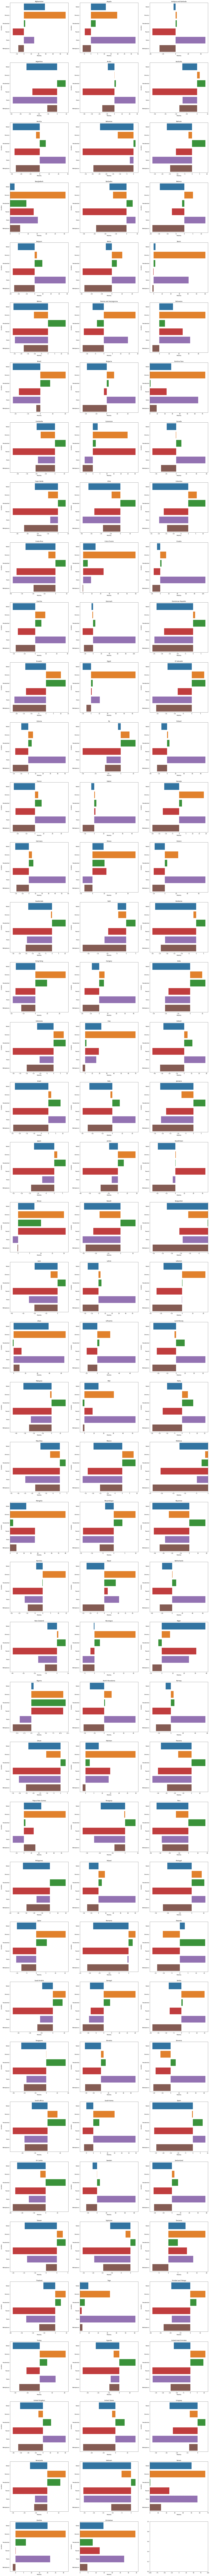

In [10]:
graph_per_row = 3
row = int(len(countries)/graph_per_row)+1
f, axes = plt.subplots(row, graph_per_row, figsize=(30, 400))
plt.xlim(-100, 100)

i = 0
for c in countries:
    country_data = merged_data.loc[merged_data['location'] == c]
    retail = country_data['retail_and_recreation'].mean()
    grocery = country_data['grocery_and_pharmacy'].mean()
    residential = country_data['residential'].mean()
    transit = country_data['transit_stations'].mean()
    parks = country_data['parks'].mean()
    workplaces = country_data['workplaces'].mean()
    mobility_location = pd.DataFrame({'Location':['Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces'], 
                                    'Mobility':[retail, grocery, residential, transit, parks, workplaces]})
    sb.barplot(x='Mobility',y='Location',data=mobility_location, ax = axes[i//graph_per_row,i%graph_per_row], orient='h').set_title(c)
    i+=1

As we can see the average mobility differs across each country. How can we group country that are similar together? To better understand and for accuracy we are going to categorise the data

# 3. K-Means clustering for countries by country's development
- Get latest data for each country
- EDA for PCA & K-Means
- Assign a cluster to every country

In [11]:
# Grab column that is needed for classification
cluster_data = pd.DataFrame(merged_data[["location", "date", "population_density", "gdp_per_capita", "life_expectancy", "human_development_index"]])
cluster_data = cluster_data.dropna()
cluster_data.head()

location        date  population_density  gdp_per_capita  \
0  Afghanistan  2020-02-24              54.422        1803.987   
1  Afghanistan  2020-02-25              54.422        1803.987   
2  Afghanistan  2020-02-26              54.422        1803.987   
3  Afghanistan  2020-02-27              54.422        1803.987   
4  Afghanistan  2020-02-28              54.422        1803.987   

   life_expectancy  human_development_index  
0            64.83                    0.511  
1            64.83                    0.511  
2            64.83                    0.511  
3            64.83                    0.511  
4            64.83                    0.511

In [12]:
# Grab the latest data by sorting first then keeping the last data for each location
cluster_data = cluster_data.sort_values(by=['date']).drop_duplicates(subset='location', keep='last')

# Reset index for ease in combination of data later on
cluster_data.reset_index(drop=True, inplace=True)
cluster_data.head()

location        date  population_density  gdp_per_capita  \
0      Vietnam  2021-10-23             308.127        6171.884   
1        Niger  2022-03-12              16.955         926.000   
2        Nepal  2022-03-12             204.430        2442.804   
3      Namibia  2022-03-12               3.078        9541.808   
4  Netherlands  2022-03-12             508.544       48472.545   

   life_expectancy  human_development_index  
0            75.40                    0.704  
1            62.42                    0.394  
2            70.78                    0.602  
3            63.71                    0.646  
4            82.28                    0.944

In [13]:
# Drop location & date in prepation for classification
kmean_data = cluster_data.drop(columns=['location' ,'date'])
kmean_data.head()

population_density  gdp_per_capita  life_expectancy  \
0             308.127        6171.884            75.40   
1              16.955         926.000            62.42   
2             204.430        2442.804            70.78   
3               3.078        9541.808            63.71   
4             508.544       48472.545            82.28   

   human_development_index  
0                    0.704  
1                    0.394  
2                    0.602  
3                    0.646  
4                    0.944

#### Analysis for K-Means

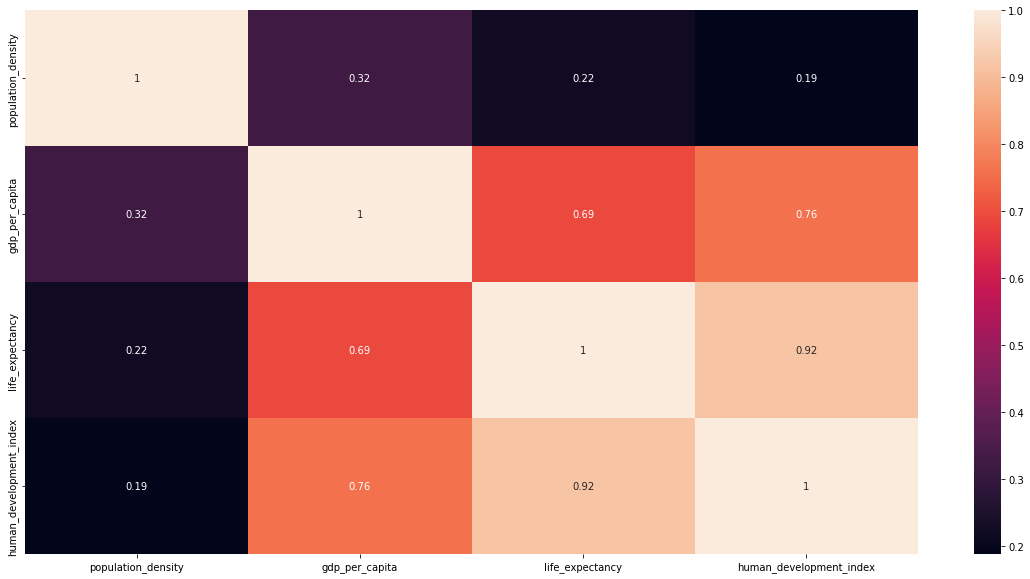

In [14]:
# Analysis for K-Means Clustering
# Plot heatmap to show correlation across data
plt.figure(figsize = (20,10))
sb.heatmap(kmean_data.corr(),annot = True)
plt.show()

In [15]:
# Scale variables to a common value
s_scaler = StandardScaler()
kmean_data_scaled = s_scaler.fit_transform(kmean_data)
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(kmean_data_scaled)
pca.components_

array([[ 0.24164155,  0.53760095,  0.56591608,  0.5764838 ],
       [ 0.95345292,  0.0219156 , -0.19287339, -0.2307533 ],
       [-0.17156409,  0.82837606, -0.4826024 , -0.22683429],
       [-0.05570143,  0.15587824,  0.64002639, -0.7503103 ]])

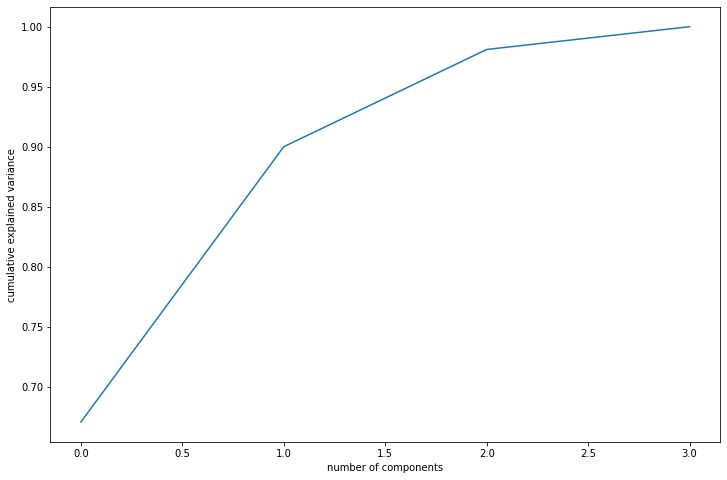

In [16]:
# Plot variance ratio 
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [17]:
# Plot PC values for each variable
colnames = list(kmean_data.columns)
pcs_df = pd.DataFrame({'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1]})
pcs_df

Feature       PC1       PC2
0       population_density  0.241642  0.953453
1           gdp_per_capita  0.537601  0.021916
2          life_expectancy  0.565916 -0.192873
3  human_development_index  0.576484 -0.230753

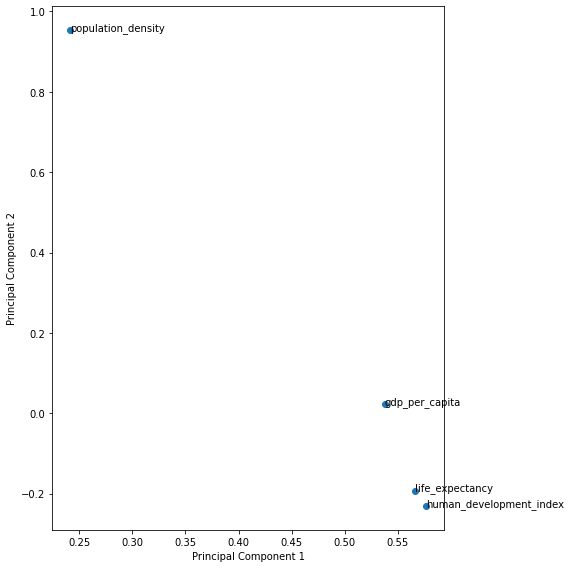

In [18]:
# Plot correlation of PC
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [19]:
# Scale variables according to analysis
pca_final = IncrementalPCA(n_components=2)
df_pca = pca_final.fit_transform(kmean_data_scaled)
df_pca.shape

(126, 2)

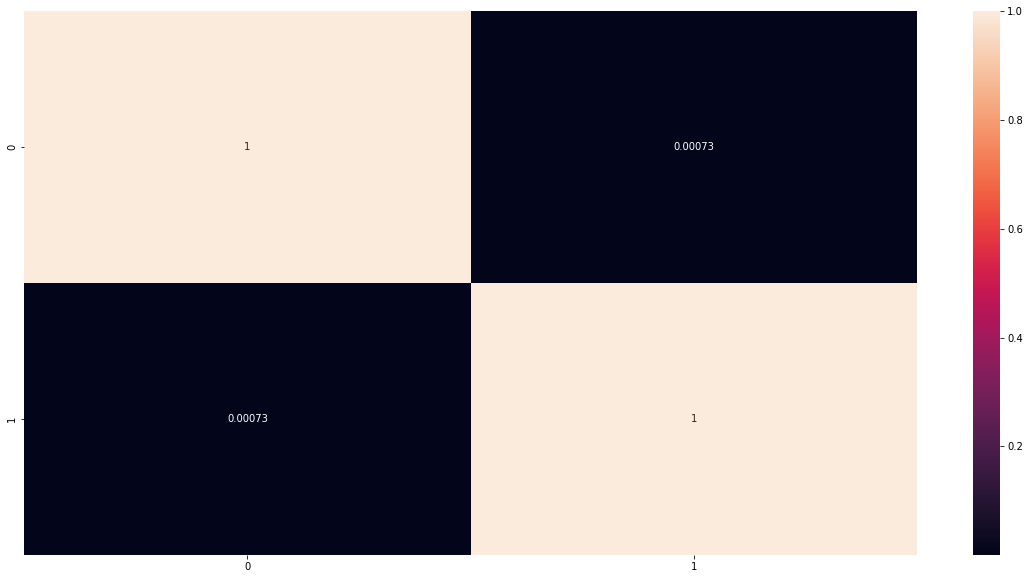

In [20]:
# Plot correlation of PCs
pc = np.transpose(df_pca)
corrmat = np.corrcoef(pc)
plt.figure(figsize=(20,10))
sb.heatmap(corrmat,annot=True)
plt.show()

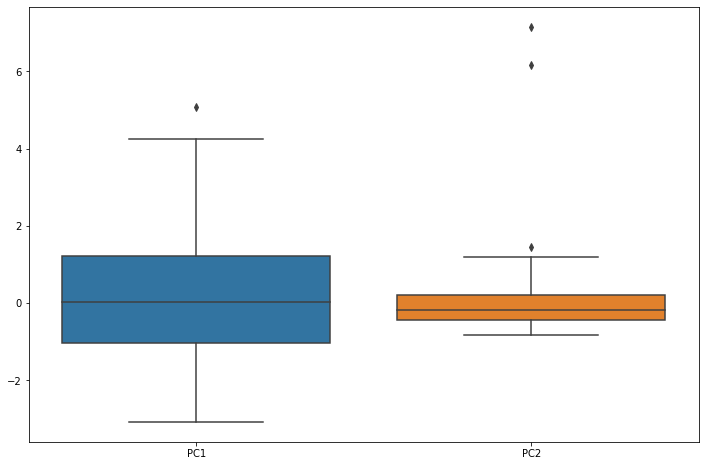

In [21]:
# Boxplot of PCs and outliers
pcs_df2 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1]})
fig = plt.figure(figsize = (12,8))
sb.boxplot(data=pcs_df2)
plt.show()

In [22]:
pcs_df2.shape

(126, 2)

In [23]:
pcs_df2.head()

PC1       PC2
0 -0.504470  0.041070
1 -3.019560  0.634132
2 -1.414386  0.234534
3 -1.675776  0.184459
4  2.173764 -0.271062

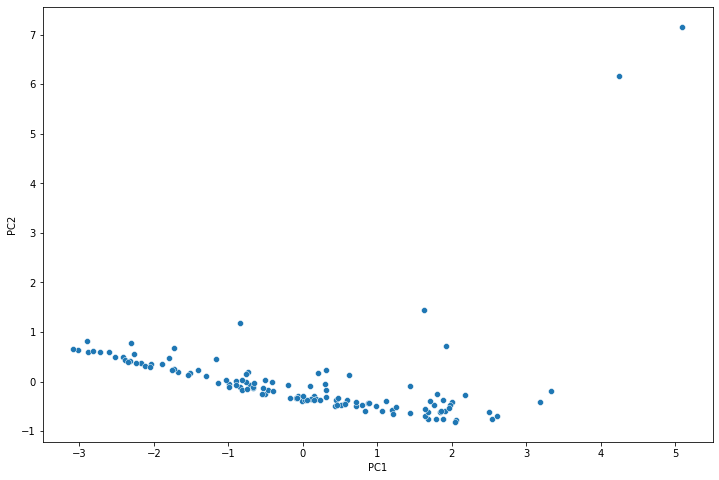

In [24]:
# Plot spread of data
fig = plt.figure(figsize = (12,8))
sb.scatterplot(x='PC1',y='PC2',data=pcs_df2)
plt.show()

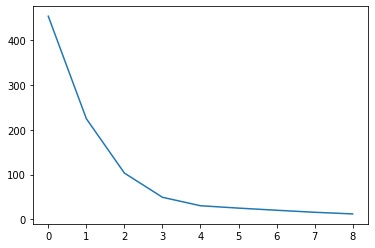

In [25]:
# Elbow plot for the most optimum number of K-Means clusters
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(pcs_df2)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.show()

In [26]:
# Fit K-Means clustering
model_clus2 = KMeans(n_clusters = 2, max_iter=50,random_state = 50)
model_clus2.fit(pcs_df2)

KMeans(max_iter=50, n_clusters=2, random_state=50)

In [27]:
# Cluster data accordingly
dat4=pcs_df2
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
dat_km.columns = ['PC1','PC2','ClusterID']
dat_km

PC1       PC2  ClusterID
0   -0.504470  0.041070          1
1   -3.019560  0.634132          1
2   -1.414386  0.234534          1
3   -1.675776  0.184459          1
4    2.173764 -0.271062          0
..        ...       ...        ...
121 -2.318970  0.409282          1
122  1.642309 -0.550550          0
123 -0.416415 -0.017917          1
124 -2.597272  0.602423          1
125 -2.347590  0.397465          1

[126 rows x 3 columns]

In [28]:
dat_km['ClusterID'].value_counts()

0    70
1    56
Name: ClusterID, dtype: int64

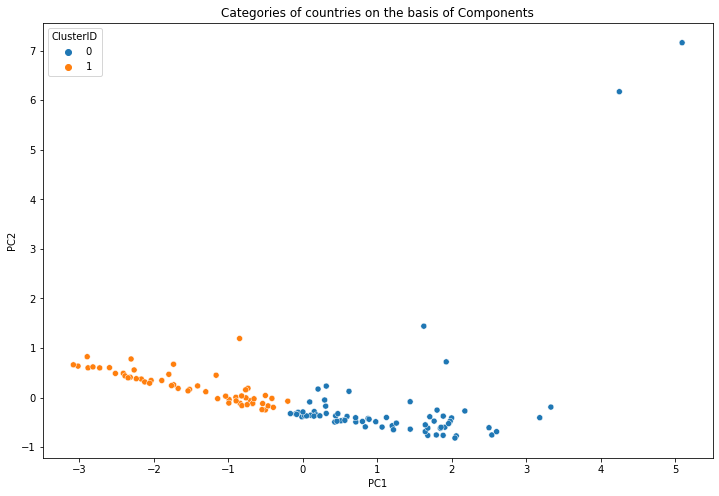

In [29]:
# Plot cluster of data
fig = plt.figure(figsize = (12,8))
sb.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

plt.title('Categories of countries on the basis of Components')
plt.show()

In [30]:
# Merge location with clustering data
dat5=pd.merge(cluster_data,dat_km, left_index=True,right_index=True)
dat5.head()

location        date  population_density  gdp_per_capita  \
0      Vietnam  2021-10-23             308.127        6171.884   
1        Niger  2022-03-12              16.955         926.000   
2        Nepal  2022-03-12             204.430        2442.804   
3      Namibia  2022-03-12               3.078        9541.808   
4  Netherlands  2022-03-12             508.544       48472.545   

   life_expectancy  human_development_index       PC1       PC2  ClusterID  
0            75.40                    0.704 -0.504470  0.041070          1  
1            62.42                    0.394 -3.019560  0.634132          1  
2            70.78                    0.602 -1.414386  0.234534          1  
3            63.71                    0.646 -1.675776  0.184459          1  
4            82.28                    0.944  2.173764 -0.271062          0

In [31]:
# Split data according to clusters
cluster1 = dat5[dat5["ClusterID"]==0]
cluster1.head()

location        date  population_density  gdp_per_capita  \
4           Netherlands  2022-03-12             508.544       48472.545   
5           New Zealand  2022-03-12              18.206       36085.843   
8   Antigua and Barbuda  2022-03-12             231.845       21490.943   
9       North Macedonia  2022-03-12              82.600       13111.214   
10             Thailand  2022-03-12             135.132       16277.671   

    life_expectancy  human_development_index       PC1       PC2  ClusterID  
4             82.28                    0.944  2.173764 -0.271062          0  
5             82.29                    0.931  1.676248 -0.764135          0  
8             77.02                    0.778  0.305033 -0.173354          0  
9             75.80                    0.774 -0.065551 -0.296724          0  
10            77.15                    0.777  0.151579 -0.282644          0

In [32]:
# Split data according to clusters
cluster2 = dat5[dat5["ClusterID"]==1]
cluster2.head()

location        date  population_density  gdp_per_capita  life_expectancy  \
0    Vietnam  2021-10-23             308.127        6171.884            75.40   
1      Niger  2022-03-12              16.955         926.000            62.42   
2      Nepal  2022-03-12             204.430        2442.804            70.78   
3    Namibia  2022-03-12               3.078        9541.808            63.71   
6  Nicaragua  2022-03-12              51.667        5321.444            74.48   

   human_development_index       PC1       PC2  ClusterID  
0                    0.704 -0.504470  0.041070          1  
1                    0.394 -3.019560  0.634132          1  
2                    0.602 -1.414386  0.234534          1  
3                    0.646 -1.675776  0.184459          1  
6                    0.660 -0.843727 -0.116647          1

### Average mobility across each clusters

In [33]:
cluster1_data = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_data.head()

iso_code      continent             location        date  total_cases  \
0      ATG  North America  Antigua and Barbuda  2020-03-13          1.0   
1      ATG  North America  Antigua and Barbuda  2020-03-14          1.0   
2      ATG  North America  Antigua and Barbuda  2020-03-15          1.0   
3      ATG  North America  Antigua and Barbuda  2020-03-16          1.0   
4      ATG  North America  Antigua and Barbuda  2020-03-17          1.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        1.0                 NaN           NaN         NaN   
1        0.0                 NaN           NaN         NaN   
2        0.0                 NaN           NaN         NaN   
3        0.0                 NaN           NaN         NaN   
4        0.0                 NaN           NaN         NaN   

   new_deaths_smoothed  ...  excess_mortality_cumulative  excess_mortality  \
0                  NaN  ...                          NaN               NaN   
1                  NaN  ...                          NaN               NaN   
2                  NaN  ...                          NaN               NaN   
3                  NaN  ...                          NaN               NaN   
4                  NaN  ...                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.429   
1                                      NaN                 -0.286   
2                                      NaN                 -2.429   
3                                      NaN                 -4.000   
4                                      NaN                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 8.286        0.500            -0.286  4.000       3.714   
1                 7.714        1.167            -2.571  2.714       2.857   
2                 7.143        1.167            -4.429 -0.571       1.714   
3                 5.857        2.500            -5.429 -1.857      -0.714   
4                 4.286        4.167            -8.000 -4.286      -3.429   

    Average  
0  2.940500  
1  1.932500  
2  0.432500  
3 -0.607167  
4 -2.448500  

[5 rows x 73 columns]

In [34]:
cluster2_data = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_data.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

In [35]:
retail_c1 = cluster1_data['retail_and_recreation'].mean()
grocery_c1 = cluster1_data['grocery_and_pharmacy'].mean()
residential_c1 = cluster1_data['residential'].mean()
transit_c1 = cluster1_data['transit_stations'].mean()
parks_c1 = cluster1_data['parks'].mean()
workplaces_c1 = cluster1_data['workplaces'].mean()

retail_c2 = cluster2_data['retail_and_recreation'].mean()
grocery_c2 = cluster2_data['grocery_and_pharmacy'].mean()
residential_c2 = cluster2_data['residential'].mean()
transit_c2 = cluster2_data['transit_stations'].mean()
parks_c2 = cluster2_data['parks'].mean()
workplaces_c2 = cluster2_data['workplaces'].mean()

cluster_a_mobility = pd.DataFrame({'Location':['Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces',
                                              'Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces'], 
                                'Average Mobility':[retail_c1, grocery_c1, residential_c1, transit_c1, parks_c1, workplaces_c1,
                                                   retail_c2, grocery_c2, residential_c2, transit_c2, parks_c2, workplaces_c2],
                                'Cluster':['1', '1', '1', '1', '1', '1',
                                          '2', '2', '2', '2', '2', '2']})
cluster_a_mobility.head(11)

Location  Average Mobility Cluster
0        Retail        -18.582049       1
1       Grocery          3.714593       1
2   Residential          7.067497       1
3       Transit        -24.705196       1
4         Parks         13.706085       1
5    Workplaces        -20.681746       1
6        Retail         -2.020971       2
7       Grocery         19.541519       2
8   Residential          6.299733       2
9       Transit         -8.149119       2
10        Parks          3.799217       2

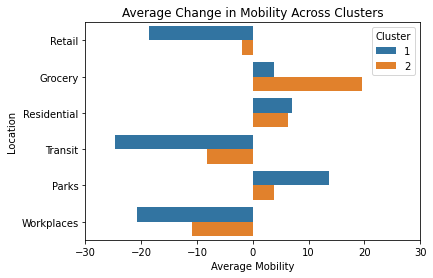

In [36]:
sb.barplot(x='Average Mobility', y='Location', hue='Cluster', data=cluster_a_mobility, orient='h')
plt.title('Average Change in Mobility Across Clusters')
plt.xlim(-30, 30)
plt.show()

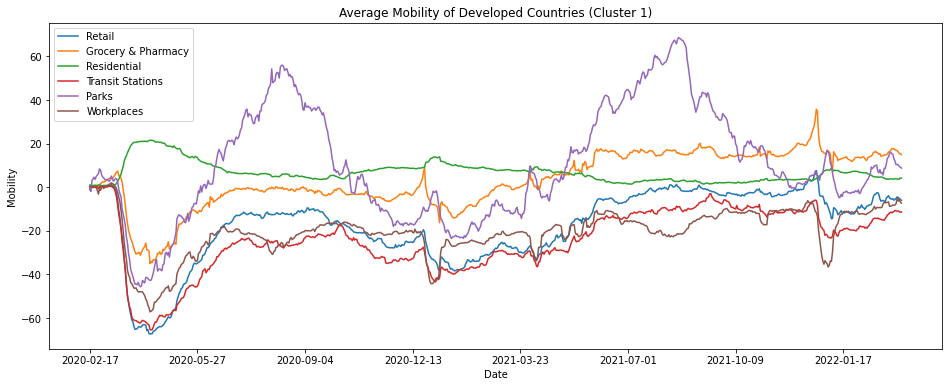

In [37]:
mobility_trend_c1 = pd.DataFrame(data = cluster1_data[["retail_and_recreation", "grocery_and_pharmacy", "residential", 
                                        "transit_stations", "parks", "workplaces"]].groupby(cluster1_data["date"]).median())
f = plt.figure(figsize=(16, 6))
mobility_trend_c1["retail_and_recreation"].plot(kind = "line", label="Retail");
mobility_trend_c1["grocery_and_pharmacy"].plot(kind = "line", label="Grocery & Pharmacy");
mobility_trend_c1["residential"].plot(kind = "line", label="Residential");
mobility_trend_c1["transit_stations"].plot(kind = "line", label="Transit Stations");
mobility_trend_c1["parks"].plot(kind = "line", label="Parks");
mobility_trend_c1["workplaces"].plot(kind = "line", label="Workplaces");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Mobility")
plt.title("Average Mobility of Developed Countries (Cluster 1)");

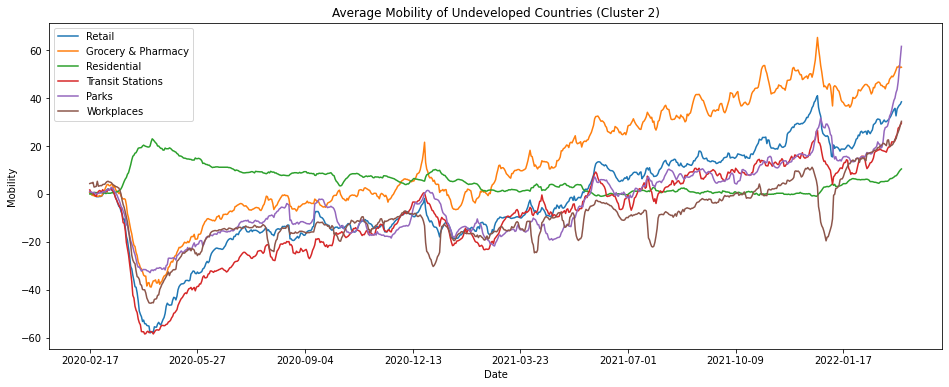

In [38]:
mobility_trend_c2 = pd.DataFrame(data = cluster2_data[["retail_and_recreation", "grocery_and_pharmacy", "residential", 
                                        "transit_stations", "parks", "workplaces"]].groupby(cluster2_data["date"]).median())
f = plt.figure(figsize=(16, 6))
mobility_trend_c2["retail_and_recreation"].plot(kind = "line", label="Retail");
mobility_trend_c2["grocery_and_pharmacy"].plot(kind = "line", label="Grocery & Pharmacy");
mobility_trend_c2["residential"].plot(kind = "line", label="Residential");
mobility_trend_c2["transit_stations"].plot(kind = "line", label="Transit Stations");
mobility_trend_c2["parks"].plot(kind = "line", label="Parks");
mobility_trend_c2["workplaces"].plot(kind = "line", label="Workplaces");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Mobility")
plt.title("Average Mobility of Undeveloped Countries (Cluster 2)");

Now, it is much easier to visulaise and understand the trends in the data after categorising them. We can observe that the average mobility influctuates over time with some drastic changes during some intervals during COVID-19. Mobility across each clusters are also trends differently (except residential).

#### To go into more details, lets take an example of people fully vaccinated

In [39]:
# Grab vaccination data
vac = pd.DataFrame(merged_data[["location", "people_fully_vaccinated"]])
vac = vac.dropna()
vac.head()

location  people_fully_vaccinated
374  Afghanistan                  55624.0
383  Afghanistan                  77560.0
387  Afghanistan                  96910.0
389  Afghanistan                 111082.0
390  Afghanistan                 113739.0

In [40]:
# Get the latest poeple fully vaccinated data
vac = vac.sort_values(by=['people_fully_vaccinated']).drop_duplicates(subset='location', keep='last')
vac.head()

location  people_fully_vaccinated
2051   Antigua and Barbuda                  61327.0
3524                 Aruba                  80693.0
34319                Haiti                 107268.0
7916              Barbados                 150337.0
5727               Bahamas                 155124.0

In [41]:
# Get latest population data
pop = pd.DataFrame(merged_data[["location", "population"]])
pop = pop.dropna()
pop = pop.sort_values(by=['population']).drop_duplicates(subset='location', keep='last')
pop.head()

location  population
1388  Antigua and Barbuda     98728.0
3494                Aruba    107195.0
7466             Barbados    287708.0
5498              Bahamas    396914.0
9588               Belize    404915.0

In [42]:
# Merge people fully vaccinated and population
vac_pop = vac.merge(pop, left_on=["location"], right_on=["location"])
vac_pop.head()

location  people_fully_vaccinated  population
0  Antigua and Barbuda                  61327.0     98728.0
1                Aruba                  80693.0    107195.0
2                Haiti                 107268.0  11541683.0
3             Barbados                 150337.0    287708.0
4              Bahamas                 155124.0    396914.0

In [43]:
# Calculate the percentage of people vaccinated in across all countries
vac_pop["vac_pop_percentage"] = (vac_pop["people_fully_vaccinated"] / vac_pop["population"]) * 100
vac_pop.head()

location  people_fully_vaccinated  population  \
0  Antigua and Barbuda                  61327.0     98728.0   
1                Aruba                  80693.0    107195.0   
2                Haiti                 107268.0  11541683.0   
3             Barbados                 150337.0    287708.0   
4              Bahamas                 155124.0    396914.0   

   vac_pop_percentage  
0           62.117130  
1           75.276832  
2            0.929397  
3           52.253326  
4           39.082522

In [44]:
# Merge data according to cluster
cluster1_pop = cluster1.merge(vac_pop, left_on=["location"], right_on=["location"])
cluster1_pop.head()

location        date  population_density  gdp_per_capita  \
0          Netherlands  2022-03-12             508.544       48472.545   
1          New Zealand  2022-03-12              18.206       36085.843   
2  Antigua and Barbuda  2022-03-12             231.845       21490.943   
3      North Macedonia  2022-03-12              82.600       13111.214   
4             Thailand  2022-03-12             135.132       16277.671   

   life_expectancy  human_development_index       PC1       PC2  ClusterID  \
0            82.28                    0.944  2.173764 -0.271062          0   
1            82.29                    0.931  1.676248 -0.764135          0   
2            77.02                    0.778  0.305033 -0.173354          0   
3            75.80                    0.774 -0.065551 -0.296724          0   
4            77.15                    0.777  0.151579 -0.282644          0   

   people_fully_vaccinated  population  vac_pop_percentage  
0               12361264.0  17173094.0           71.980413  
1                3976247.0   5126300.0           77.565632  
2                  61327.0     98728.0           62.117130  
3                 834203.0   2082661.0           40.054670  
4               49893668.0  69950844.0           71.326756

In [45]:
cluster1_pop.describe()[["vac_pop_percentage"]]

vac_pop_percentage
count           70.000000
mean            67.850549
std             15.673898
min             25.925866
25%             61.213572
50%             71.663849
75%             78.173257
max             95.426812

In [46]:
# Merge data according to cluster
cluster2_pop = cluster2.merge(vac_pop, left_on=["location"], right_on=["location"])
cluster2_pop.head()

location        date  population_density  gdp_per_capita  life_expectancy  \
0    Vietnam  2021-10-23             308.127        6171.884            75.40   
1      Niger  2022-03-12              16.955         926.000            62.42   
2      Nepal  2022-03-12             204.430        2442.804            70.78   
3    Namibia  2022-03-12               3.078        9541.808            63.71   
4  Nicaragua  2022-03-12              51.667        5321.444            74.48   

   human_development_index       PC1       PC2  ClusterID  \
0                    0.704 -0.504470  0.041070          1   
1                    0.394 -3.019560  0.634132          1   
2                    0.602 -1.414386  0.234534          1   
3                    0.646 -1.675776  0.184459          1   
4                    0.660 -0.843727 -0.116647          1   

   people_fully_vaccinated  population  vac_pop_percentage  
0               21045837.0  98168829.0           21.438411  
1                1541167.0  25130810.0            6.132580  
2               18399451.0  29674920.0           62.003372  
3                 378399.0   2587344.0           14.624998  
4                4113547.0   6702379.0           61.374431

In [47]:
cluster2_pop.describe()[["vac_pop_percentage"]]

vac_pop_percentage
count           56.000000
mean            31.569868
std             22.388370
min              0.929397
25%             12.827780
50%             27.469947
75%             51.896703
max             81.905516

In [48]:
cluster_pop_avg = pd.DataFrame({'Cluster_ID':['Cluster 1', 'Cluster 2'], 'Vac_Rate':[cluster1_pop["vac_pop_percentage"].mean(), cluster2_pop["vac_pop_percentage"].mean()]})
cluster_pop_avg.head()

Cluster_ID   Vac_Rate
0  Cluster 1  67.850549
1  Cluster 2  31.569868

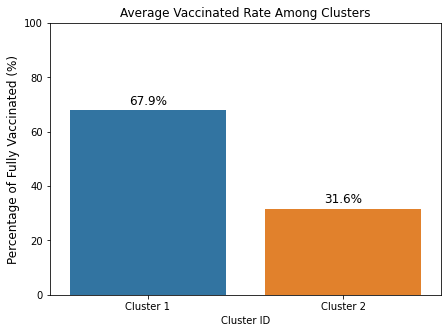

In [49]:
fig = plt.figure(figsize = (7,5))
s=sb.barplot(x='Cluster_ID',y='Vac_Rate',data=cluster_pop_avg)
plt.bar_label(s.containers[0], fmt='%.1f%%', padding=3, fontsize=12)
plt.xlabel('Cluster ID', fontsize=10)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Average Vaccinated Rate Among Clusters')
plt.ylim(0, 100)
plt.show()

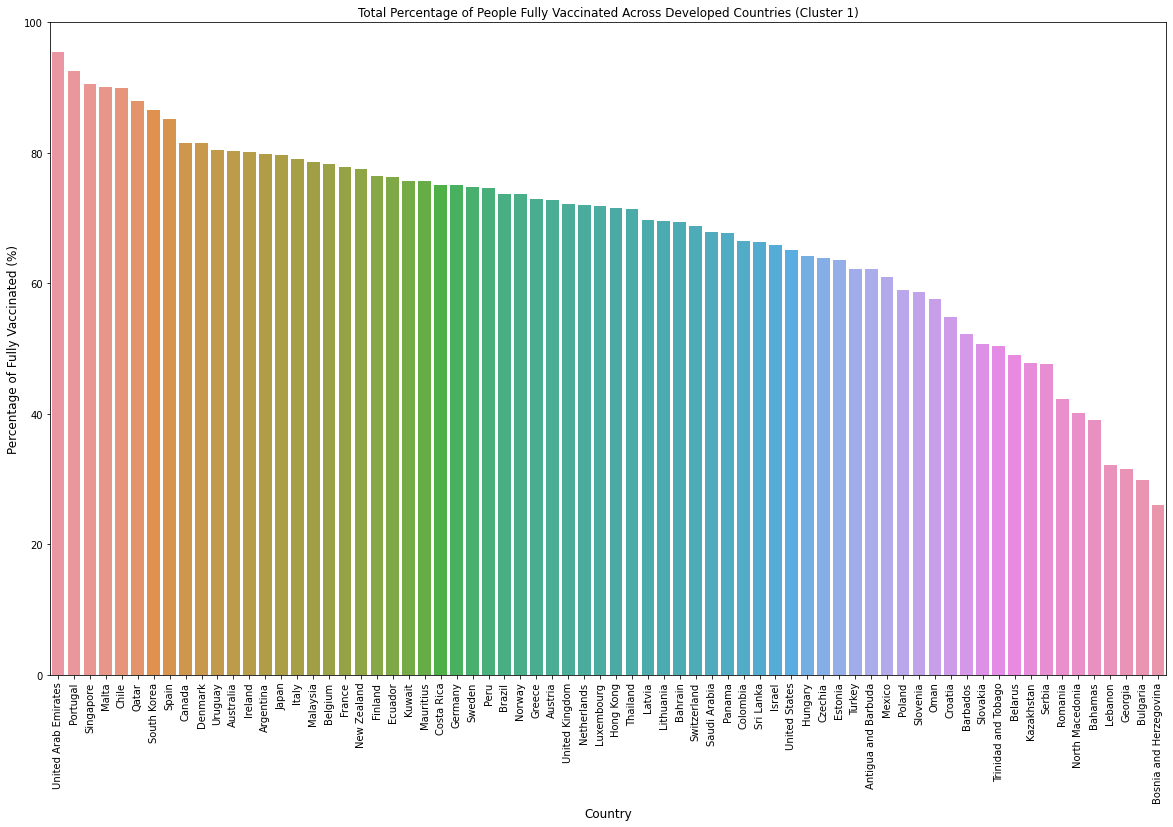

In [104]:
# Plot vaccination data for countries in cluster
fig = plt.figure(figsize = (20,12))
s=sb.barplot(x='location',y='vac_pop_percentage',data=cluster1_pop.sort_values("vac_pop_percentage", ascending=False))
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Total Percentage of People Fully Vaccinated Across Developed Countries (Cluster 1)')
plt.ylim(0, 100)
plt.show()

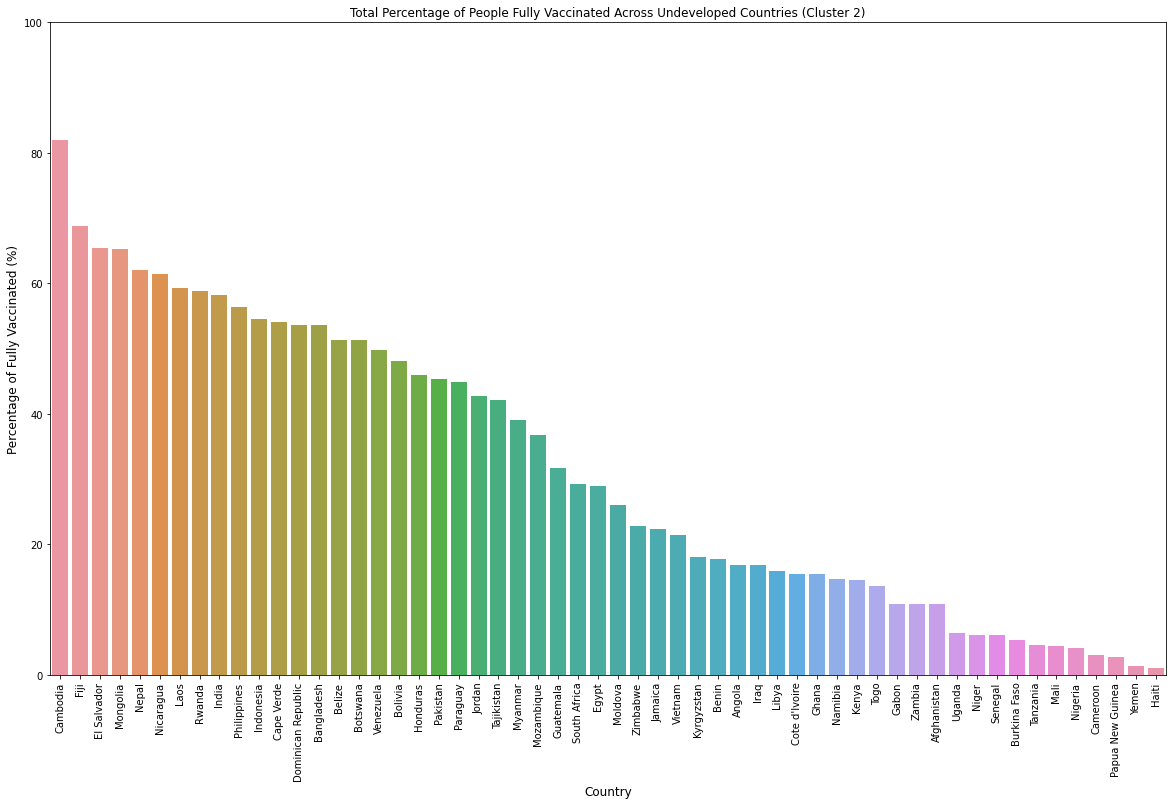

In [105]:
# Plot vaccination data for countries in cluster
fig = plt.figure(figsize = (20,12))
s=sb.barplot(x='location',y='vac_pop_percentage',data=cluster2_pop.sort_values("vac_pop_percentage", ascending=False))
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Total Percentage of People Fully Vaccinated Across Undeveloped Countries (Cluster 2)')
plt.ylim(0, 100)
plt.show()

Vaccination rate differs by a lot from each clusters. From this we can see how much difference there is between the two clusters.

# 4. Further Exploratory Data Analysis
- Analysisng and visualising the factors 
- Get a better understanding of the the data before regression

## 4.1 Number of ICU patients per million across the clusters

In [52]:
cluster1_icu = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_icu.head()

iso_code      continent             location        date  total_cases  \
0      ATG  North America  Antigua and Barbuda  2020-03-13          1.0   
1      ATG  North America  Antigua and Barbuda  2020-03-14          1.0   
2      ATG  North America  Antigua and Barbuda  2020-03-15          1.0   
3      ATG  North America  Antigua and Barbuda  2020-03-16          1.0   
4      ATG  North America  Antigua and Barbuda  2020-03-17          1.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        1.0                 NaN           NaN         NaN   
1        0.0                 NaN           NaN         NaN   
2        0.0                 NaN           NaN         NaN   
3        0.0                 NaN           NaN         NaN   
4        0.0                 NaN           NaN         NaN   

   new_deaths_smoothed  ...  excess_mortality_cumulative  excess_mortality  \
0                  NaN  ...                          NaN               NaN   
1                  NaN  ...                          NaN               NaN   
2                  NaN  ...                          NaN               NaN   
3                  NaN  ...                          NaN               NaN   
4                  NaN  ...                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.429   
1                                      NaN                 -0.286   
2                                      NaN                 -2.429   
3                                      NaN                 -4.000   
4                                      NaN                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 8.286        0.500            -0.286  4.000       3.714   
1                 7.714        1.167            -2.571  2.714       2.857   
2                 7.143        1.167            -4.429 -0.571       1.714   
3                 5.857        2.500            -5.429 -1.857      -0.714   
4                 4.286        4.167            -8.000 -4.286      -3.429   

    Average  
0  2.940500  
1  1.932500  
2  0.432500  
3 -0.607167  
4 -2.448500  

[5 rows x 73 columns]

In [53]:
cluster1_icu[["icu_patients_per_million"]].describe()

icu_patients_per_million
count              22055.000000
mean                  24.947445
std                   28.530440
min                    0.000000
25%                    4.422500
50%                   14.192000
75%                   36.063000
max                  177.282000

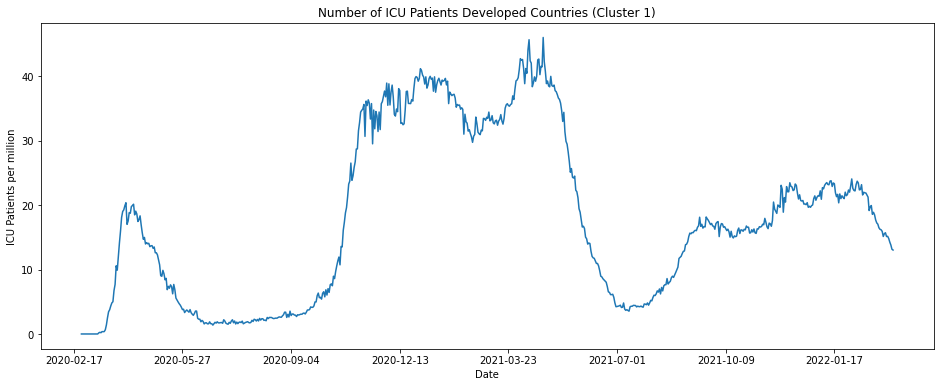

In [54]:
cluster1_icu_g = pd.DataFrame(data = cluster1_icu[["icu_patients_per_million", "date"]].groupby(cluster1_icu["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_icu_g["icu_patients_per_million"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("ICU Patients per million")
plt.title("Number of ICU Patients Developed Countries (Cluster 1)");

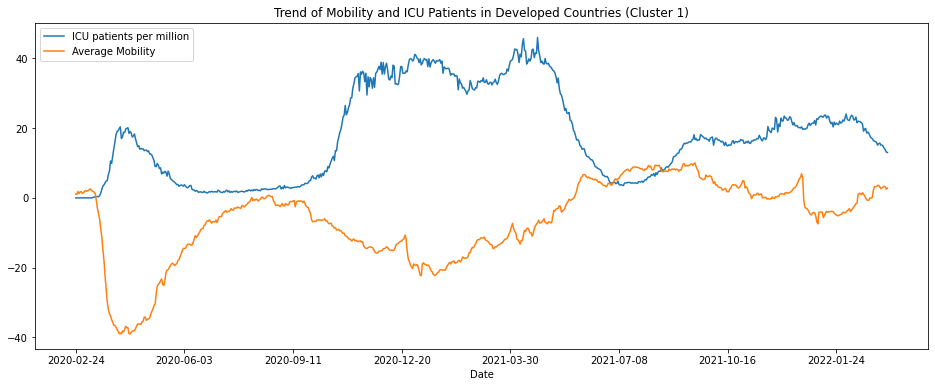

In [55]:
cluster1_icu_g2 = pd.DataFrame(data = cluster1_icu[["Average", "icu_patients_per_million"]].groupby(cluster1_icu["date"]).median())
cluster1_icu_g2 = cluster1_icu_g2.dropna()
f = plt.figure(figsize=(16, 6))
cluster1_icu_g2["icu_patients_per_million"].plot(kind = "line", label="ICU patients per million");
cluster1_icu_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and ICU Patients in Developed Countries (Cluster 1)");

From the graph we can observe that as the number of ICU patients in countries of cluster 1 spike, the mobility drops. This shows that there is a strong correlation of ICU patients and mobility in cluster 1.

In [56]:
cluster2_icu = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_icu.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

In [57]:
cluster2_icu[["icu_patients_per_million"]].describe()

icu_patients_per_million
count                309.000000
mean                   9.986126
std                    4.178323
min                    3.296000
25%                    6.254000
50%                    9.634000
75%                   12.846000
max                   19.860000

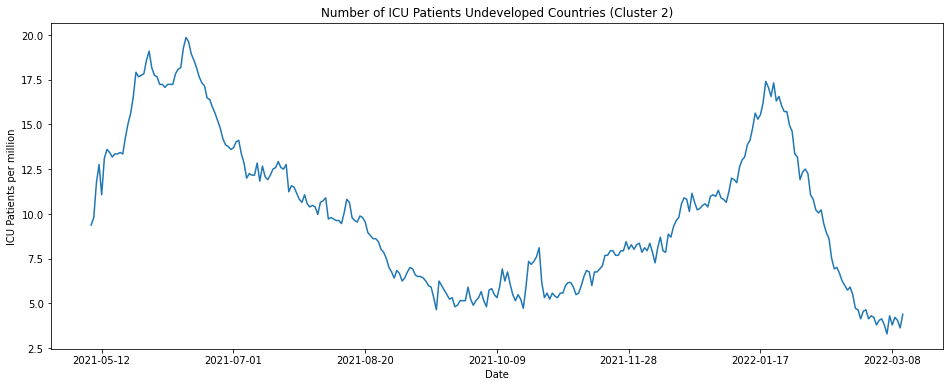

In [58]:
cluster2_icu_g = pd.DataFrame(data = cluster2_icu[["icu_patients_per_million", "date"]].groupby(cluster2_icu["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_icu_g["icu_patients_per_million"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("ICU Patients per million")
plt.title("Number of ICU Patients Undeveloped Countries (Cluster 2)");

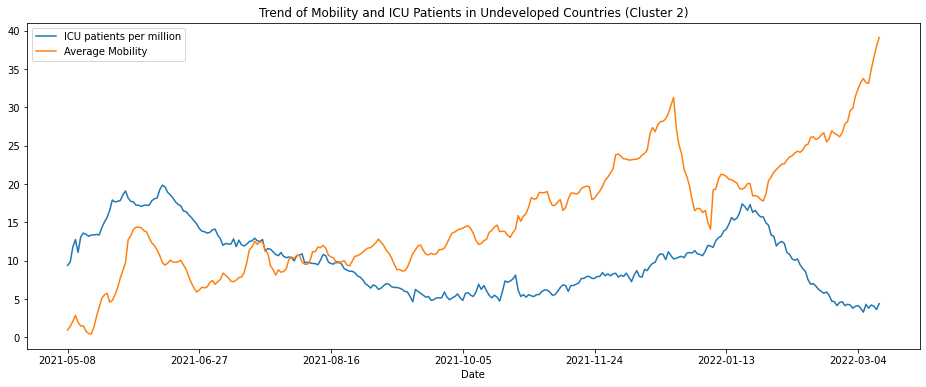

In [59]:
cluster2_icu_g2 = pd.DataFrame(data = cluster2_icu[["Average", "icu_patients_per_million"]].groupby(cluster2_icu["date"]).median())
cluster2_icu_g2 = cluster2_icu_g2.dropna()
f = plt.figure(figsize=(16, 6))
cluster2_icu_g2["icu_patients_per_million"].plot(kind = "line", label="ICU patients per million");
cluster2_icu_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and ICU Patients in Undeveloped Countries (Cluster 2)");

From the graph we can observe that unlike cluster 1, cluster 2 mobility is not affected by number of ICU patients as much.

In general, the spike of cases in ICU patients at around Jan 2022 is lower in cluster 1 compared to cluster 2. This might be due to the higher number of population that are fully vaccinated in cluster 1. 

From observing the average ICU patients per cluster, cluster 1 generally have higher ICU patients but, this may be due to the higher capacity of hospital/ICU beds in developed countries compared to undeveloped countries.

## 4.2 Stringency Index

In [60]:
cluster1_si = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_si.head()

iso_code      continent             location        date  total_cases  \
0      ATG  North America  Antigua and Barbuda  2020-03-13          1.0   
1      ATG  North America  Antigua and Barbuda  2020-03-14          1.0   
2      ATG  North America  Antigua and Barbuda  2020-03-15          1.0   
3      ATG  North America  Antigua and Barbuda  2020-03-16          1.0   
4      ATG  North America  Antigua and Barbuda  2020-03-17          1.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        1.0                 NaN           NaN         NaN   
1        0.0                 NaN           NaN         NaN   
2        0.0                 NaN           NaN         NaN   
3        0.0                 NaN           NaN         NaN   
4        0.0                 NaN           NaN         NaN   

   new_deaths_smoothed  ...  excess_mortality_cumulative  excess_mortality  \
0                  NaN  ...                          NaN               NaN   
1                  NaN  ...                          NaN               NaN   
2                  NaN  ...                          NaN               NaN   
3                  NaN  ...                          NaN               NaN   
4                  NaN  ...                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.429   
1                                      NaN                 -0.286   
2                                      NaN                 -2.429   
3                                      NaN                 -4.000   
4                                      NaN                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 8.286        0.500            -0.286  4.000       3.714   
1                 7.714        1.167            -2.571  2.714       2.857   
2                 7.143        1.167            -4.429 -0.571       1.714   
3                 5.857        2.500            -5.429 -1.857      -0.714   
4                 4.286        4.167            -8.000 -4.286      -3.429   

    Average  
0  2.940500  
1  1.932500  
2  0.432500  
3 -0.607167  
4 -2.448500  

[5 rows x 73 columns]

In [61]:
cluster1_si.describe()[['stringency_index']]

stringency_index
count      50210.000000
mean          57.195342
std           18.092046
min            0.000000
25%           44.440000
50%           56.940000
75%           71.300000
max          100.000000

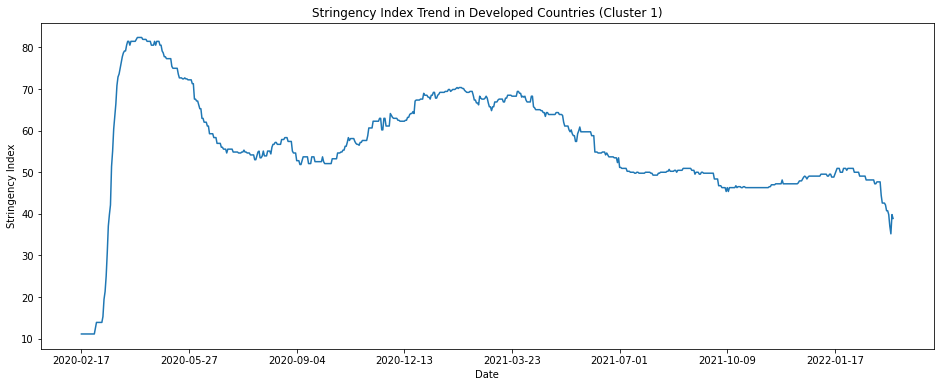

In [106]:
cluster1_si_g = pd.DataFrame(data = cluster1_si[["stringency_index", "date"]].groupby(cluster1_si["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_si_g["stringency_index"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Stringency Index")
plt.title("Stringency Index Trend in Developed Countries (Cluster 1)");

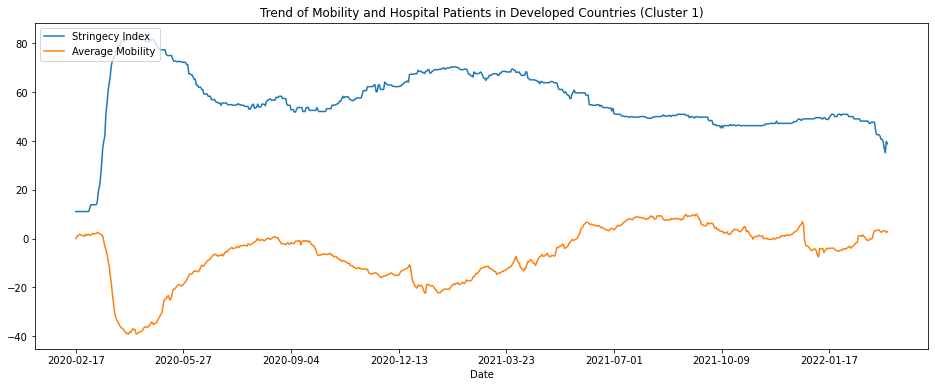

In [63]:
cluster1_si_g2 = pd.DataFrame(data = cluster1_si[["Average", "stringency_index"]].groupby(cluster1_si["date"]).median())
cluster1_si_g2 = cluster1_si_g2.dropna()
f = plt.figure(figsize=(16, 6))
cluster1_si_g2["stringency_index"].plot(kind = "line", label="Stringecy Index");
cluster1_si_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and Hospital Patients in Developed Countries (Cluster 1)");

From the graph we can observe that as stringency index goes up, mobility in cluster 1 is affected. This shows that there is a strong correlation of both variables in cluster 1.

In [64]:
cluster2_si = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_si.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

In [65]:
cluster2_si.describe()[['stringency_index']]

stringency_index
count      39918.000000
mean          54.779061
std           22.107465
min            0.000000
25%           38.890000
50%           55.560000
75%           71.760000
max          100.000000

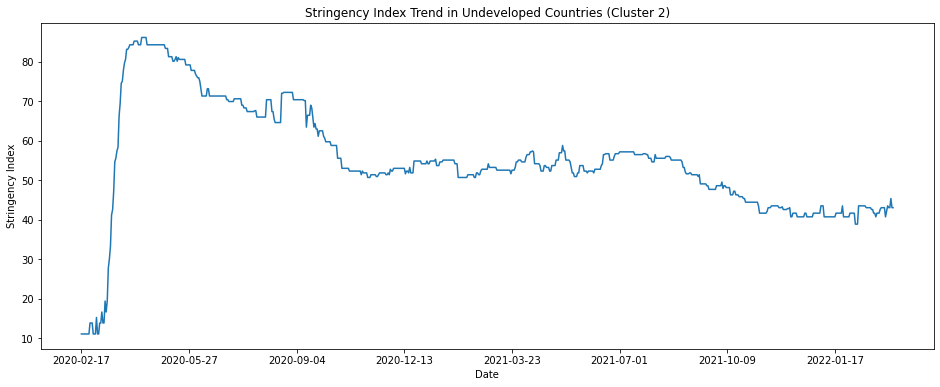

In [66]:
cluster2_si_g = pd.DataFrame(data = cluster2_si[["stringency_index", "date"]].groupby(cluster2_si["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_si_g["stringency_index"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Stringency Index")
plt.title("Stringency Index Trend in Undeveloped Countries (Cluster 2)");

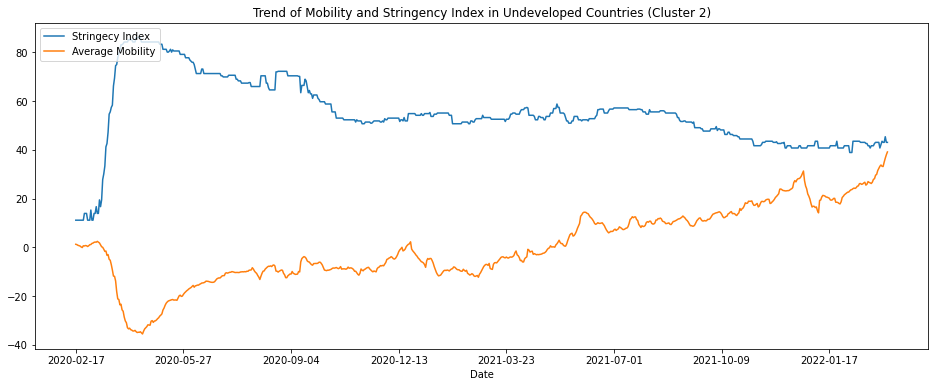

In [67]:
cluster2_si_g2 = pd.DataFrame(data = cluster2_si[["Average", "stringency_index"]].groupby(cluster2_si["date"]).median())
cluster2_si_g2 = cluster2_si_g2.dropna()
f = plt.figure(figsize=(16, 6))
cluster2_si_g2["stringency_index"].plot(kind = "line", label="Stringecy Index");
cluster2_si_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and Stringency Index in Undeveloped Countries (Cluster 2)");

From the graph we can observe that the data is similar to cluster 1. When stringency index goes up, the mobility in cluster 2 drops. This shows that both variables in cluster 2 are correlated.

## 4.3 Number of People Vaccinated per Hundred

In [68]:
cluster1_va = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_va.head()

iso_code      continent             location        date  total_cases  \
0      ATG  North America  Antigua and Barbuda  2020-03-13          1.0   
1      ATG  North America  Antigua and Barbuda  2020-03-14          1.0   
2      ATG  North America  Antigua and Barbuda  2020-03-15          1.0   
3      ATG  North America  Antigua and Barbuda  2020-03-16          1.0   
4      ATG  North America  Antigua and Barbuda  2020-03-17          1.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        1.0                 NaN           NaN         NaN   
1        0.0                 NaN           NaN         NaN   
2        0.0                 NaN           NaN         NaN   
3        0.0                 NaN           NaN         NaN   
4        0.0                 NaN           NaN         NaN   

   new_deaths_smoothed  ...  excess_mortality_cumulative  excess_mortality  \
0                  NaN  ...                          NaN               NaN   
1                  NaN  ...                          NaN               NaN   
2                  NaN  ...                          NaN               NaN   
3                  NaN  ...                          NaN               NaN   
4                  NaN  ...                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.429   
1                                      NaN                 -0.286   
2                                      NaN                 -2.429   
3                                      NaN                 -4.000   
4                                      NaN                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 8.286        0.500            -0.286  4.000       3.714   
1                 7.714        1.167            -2.571  2.714       2.857   
2                 7.143        1.167            -4.429 -0.571       1.714   
3                 5.857        2.500            -5.429 -1.857      -0.714   
4                 4.286        4.167            -8.000 -4.286      -3.429   

    Average  
0  2.940500  
1  1.932500  
2  0.432500  
3 -0.607167  
4 -2.448500  

[5 rows x 73 columns]

In [69]:
cluster1_si.describe()[['people_vaccinated_per_hundred']]

people_vaccinated_per_hundred
count                   21270.000000
mean                       45.125325
std                        28.668663
min                         0.000000
25%                        16.162500
50%                        50.890000
75%                        70.840000
max                        98.990000

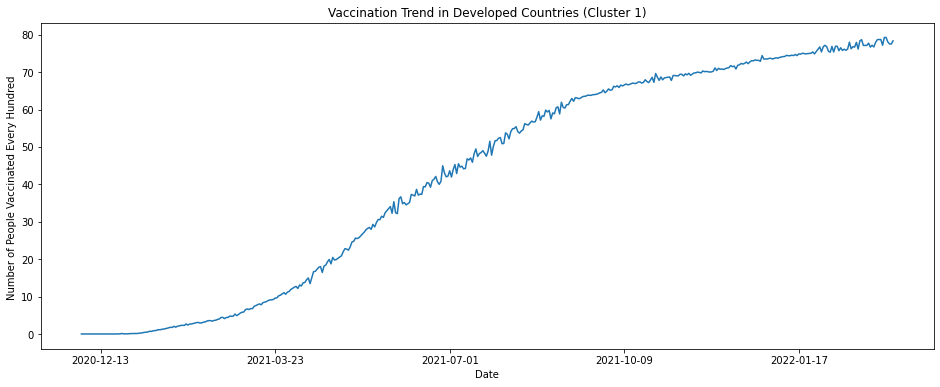

In [70]:
cluster1_va_g = pd.DataFrame(data = cluster1_va[["people_vaccinated_per_hundred", "date"]].groupby(cluster1_va["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_va_g["people_vaccinated_per_hundred"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Number of People Vaccinated Every Hundred ")
plt.title("Vaccination Trend in Developed Countries (Cluster 1)");

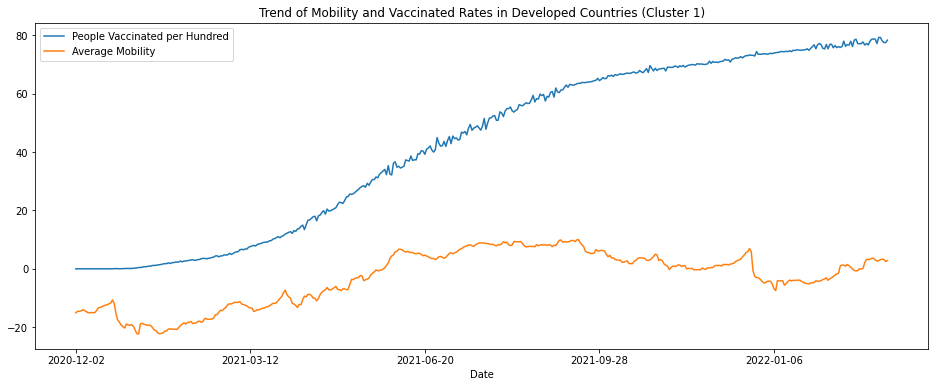

In [71]:
cluster1_va_g2 = pd.DataFrame(data = cluster1_va[["Average", "people_vaccinated_per_hundred"]].groupby(cluster1_va["date"]).median())
cluster1_va_g2 = cluster1_va_g2.dropna()
f = plt.figure(figsize=(16, 6))
cluster1_va_g2["people_vaccinated_per_hundred"].plot(kind = "line", label="People Vaccinated per Hundred");
cluster1_va_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and Vaccinated Rates in Developed Countries (Cluster 1)");

From the graph we can observe that as the vaccination rate goes up, mobility in cluster 1 increases as well. However, vaccination rate does not really affect the drop/spike in mobility. The drop/spike in mobility might be due to other variables.

In [72]:
cluster2_va = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_va.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

In [73]:
cluster2_si.describe()[['people_vaccinated_per_hundred']]

people_vaccinated_per_hundred
count                    7454.000000
mean                       22.441952
std                        23.043657
min                         0.000000
25%                         2.820000
50%                        14.220000
75%                        35.647500
max                        87.020000

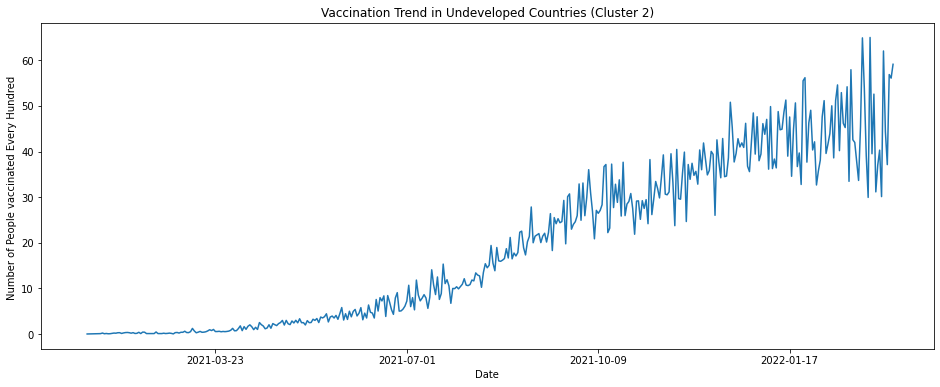

In [74]:
cluster2_va_g = pd.DataFrame(data = cluster2_va[["people_vaccinated_per_hundred", "date"]].groupby(cluster2_va["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_va_g["people_vaccinated_per_hundred"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Number of People vaccinated Every Hundred ")
plt.title("Vaccination Trend in Undeveloped Countries (Cluster 2)");

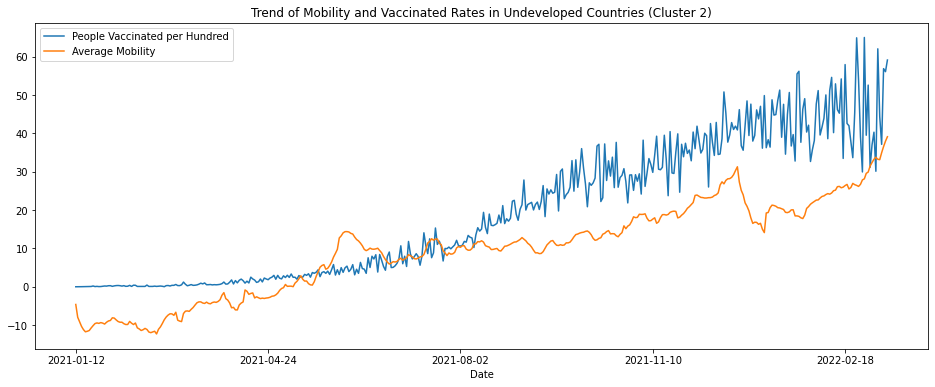

In [75]:
cluster2_va_g2 = pd.DataFrame(data = cluster2_va[["Average", "people_vaccinated_per_hundred"]].groupby(cluster2_va["date"]).median())
cluster2_va_g2 = cluster2_va_g2.dropna()
f = plt.figure(figsize=(16, 6))
cluster2_va_g2["people_vaccinated_per_hundred"].plot(kind = "line", label="People Vaccinated per Hundred");
cluster2_va_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and Vaccinated Rates in Undeveloped Countries (Cluster 2)");

From the graph we can observe that similar to cluster 1, as vaccination rate goes up, so does mobility. However vacctionation rate does not really determine the drop/spike in mobility. This may be due to other factors.

The data of vaccation rate in cluster 2 might not be accurate as well. From the time series line of 'People Vaccinated per Hundred' the trend drop and spikes over times. This is not people as the number of people vaccinated can not decrease but only increase. You cannot be suddenly 'unvaccinated' after being vaccinated. Hence, the data might not be accurate when there is a drop.

## 4.4 Cardiovascular Death Rate

In [76]:
cluster1_dr = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_dr.head()

iso_code      continent             location        date  total_cases  \
0      ATG  North America  Antigua and Barbuda  2020-03-13          1.0   
1      ATG  North America  Antigua and Barbuda  2020-03-14          1.0   
2      ATG  North America  Antigua and Barbuda  2020-03-15          1.0   
3      ATG  North America  Antigua and Barbuda  2020-03-16          1.0   
4      ATG  North America  Antigua and Barbuda  2020-03-17          1.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        1.0                 NaN           NaN         NaN   
1        0.0                 NaN           NaN         NaN   
2        0.0                 NaN           NaN         NaN   
3        0.0                 NaN           NaN         NaN   
4        0.0                 NaN           NaN         NaN   

   new_deaths_smoothed  ...  excess_mortality_cumulative  excess_mortality  \
0                  NaN  ...                          NaN               NaN   
1                  NaN  ...                          NaN               NaN   
2                  NaN  ...                          NaN               NaN   
3                  NaN  ...                          NaN               NaN   
4                  NaN  ...                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.429   
1                                      NaN                 -0.286   
2                                      NaN                 -2.429   
3                                      NaN                 -4.000   
4                                      NaN                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 8.286        0.500            -0.286  4.000       3.714   
1                 7.714        1.167            -2.571  2.714       2.857   
2                 7.143        1.167            -4.429 -0.571       1.714   
3                 5.857        2.500            -5.429 -1.857      -0.714   
4                 4.286        4.167            -8.000 -4.286      -3.429   

    Average  
0  2.940500  
1  1.932500  
2  0.432500  
3 -0.607167  
4 -2.448500  

[5 rows x 73 columns]

In [77]:
cluster1_dr.describe()[['cardiovasc_death_rate']]

cardiovasc_death_rate
count           51205.000000
mean              196.166220
std               101.970954
min                79.370000
25%               124.240000
50%               156.139000
75%               255.569000
max               496.218000

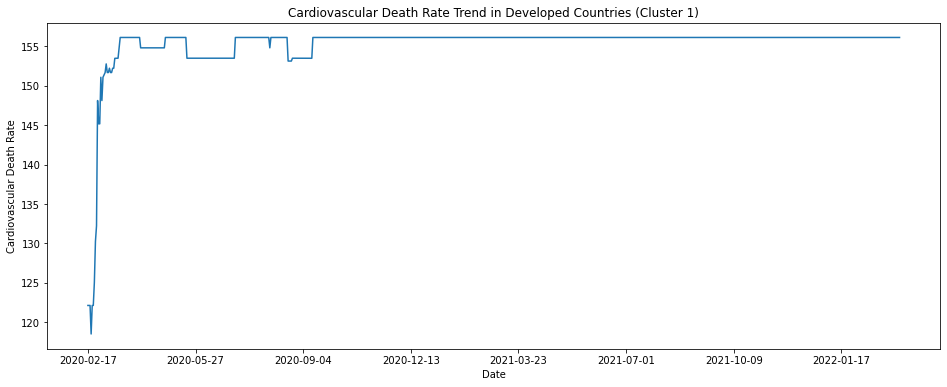

In [78]:
cluster1_dr_g = pd.DataFrame(data = cluster1_dr[["cardiovasc_death_rate", "date"]].groupby(cluster1_dr["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_dr_g["cardiovasc_death_rate"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Cardiovascular Death Rate")
plt.title("Cardiovascular Death Rate Trend in Developed Countries (Cluster 1)");

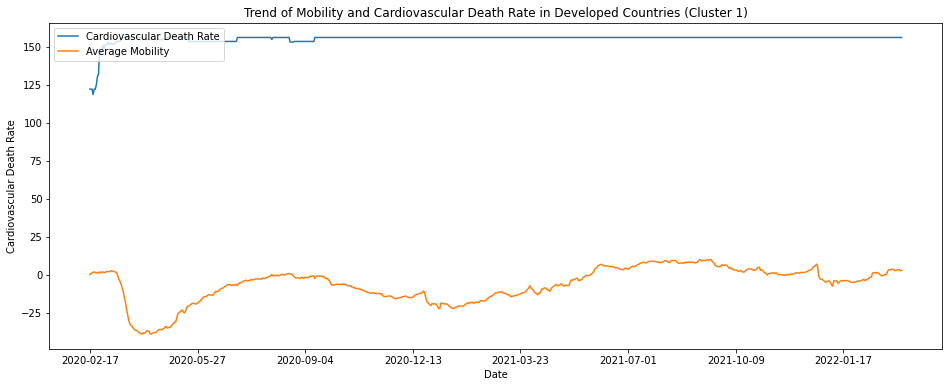

In [79]:
cluster1_dr_g2 = pd.DataFrame(data = cluster1_dr[["Average", "cardiovasc_death_rate"]].groupby(cluster1_dr["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_dr_g2["cardiovasc_death_rate"].plot(kind = "line", label="Cardiovascular Death Rate");
cluster1_dr_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Cardiovascular Death Rate")
plt.title("Trend of Mobility and Cardiovascular Death Rate in Developed Countries (Cluster 1)");

From the graph, we correlation of cardiovascular death rate is stagnant as does not affect mobility at all.

In [80]:
cluster2_dr = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_dr.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

In [81]:
cluster2_dr.describe()[['cardiovasc_death_rate']]

cardiovasc_death_rate
count           40351.000000
mean              289.048192
std               105.043357
min               137.016000
25%               208.257000
50%               260.797000
75%               341.862000
max               597.029000

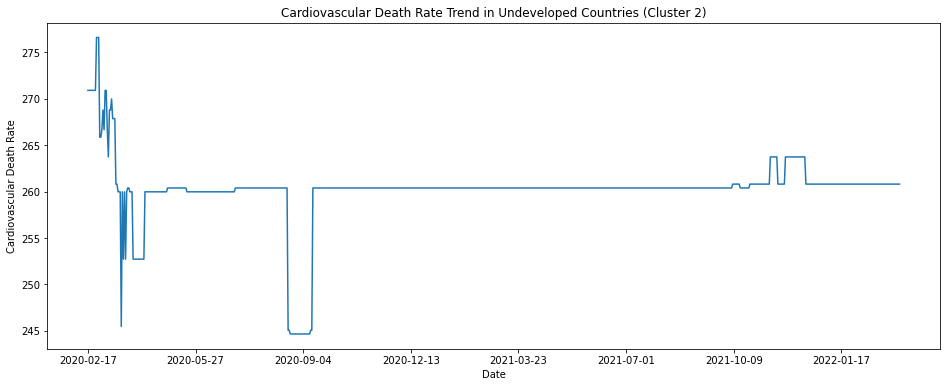

In [82]:
cluster2_dr_g = pd.DataFrame(data = cluster2_dr[["cardiovasc_death_rate", "date"]].groupby(cluster2_dr["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_dr_g["cardiovasc_death_rate"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Cardiovascular Death Rate")
plt.title("Cardiovascular Death Rate Trend in Undeveloped Countries (Cluster 2)");

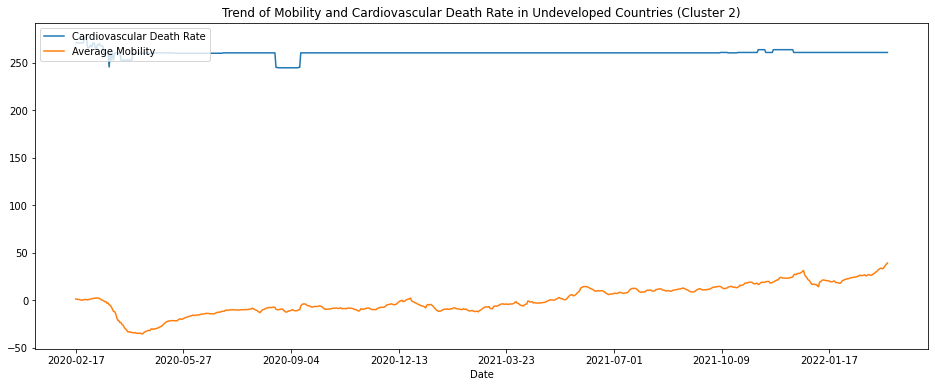

In [83]:
cluster2_dr_g2 = pd.DataFrame(data = cluster2_dr[["Average", "cardiovasc_death_rate"]].groupby(cluster2_dr["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_dr_g2["cardiovasc_death_rate"].plot(kind = "line", label="Cardiovascular Death Rate");
cluster2_dr_g2["Average"].plot(kind = "line", label="Average Mobility");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.title("Trend of Mobility and Cardiovascular Death Rate in Undeveloped Countries (Cluster 2)");

From the graph, we correlation of cardiovascular death rate is stagnant as does not affect mobility at all.

## 4.5 Population aged 70 years and older 

In [84]:
cluster1_yr = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_yr.head()

iso_code      continent             location        date  total_cases  \
0      ATG  North America  Antigua and Barbuda  2020-03-13          1.0   
1      ATG  North America  Antigua and Barbuda  2020-03-14          1.0   
2      ATG  North America  Antigua and Barbuda  2020-03-15          1.0   
3      ATG  North America  Antigua and Barbuda  2020-03-16          1.0   
4      ATG  North America  Antigua and Barbuda  2020-03-17          1.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        1.0                 NaN           NaN         NaN   
1        0.0                 NaN           NaN         NaN   
2        0.0                 NaN           NaN         NaN   
3        0.0                 NaN           NaN         NaN   
4        0.0                 NaN           NaN         NaN   

   new_deaths_smoothed  ...  excess_mortality_cumulative  excess_mortality  \
0                  NaN  ...                          NaN               NaN   
1                  NaN  ...                          NaN               NaN   
2                  NaN  ...                          NaN               NaN   
3                  NaN  ...                          NaN               NaN   
4                  NaN  ...                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.429   
1                                      NaN                 -0.286   
2                                      NaN                 -2.429   
3                                      NaN                 -4.000   
4                                      NaN                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 8.286        0.500            -0.286  4.000       3.714   
1                 7.714        1.167            -2.571  2.714       2.857   
2                 7.143        1.167            -4.429 -0.571       1.714   
3                 5.857        2.500            -5.429 -1.857      -0.714   
4                 4.286        4.167            -8.000 -4.286      -3.429   

    Average  
0  2.940500  
1  1.932500  
2  0.432500  
3 -0.607167  
4 -2.448500  

[5 rows x 73 columns]

In [85]:
cluster1_yr.describe()[['aged_70_older']]

aged_70_older
count   51259.000000
mean        9.072798
std         4.254358
min         0.526000
25%         5.331000
50%         9.788000
75%        12.644000
max        18.493000

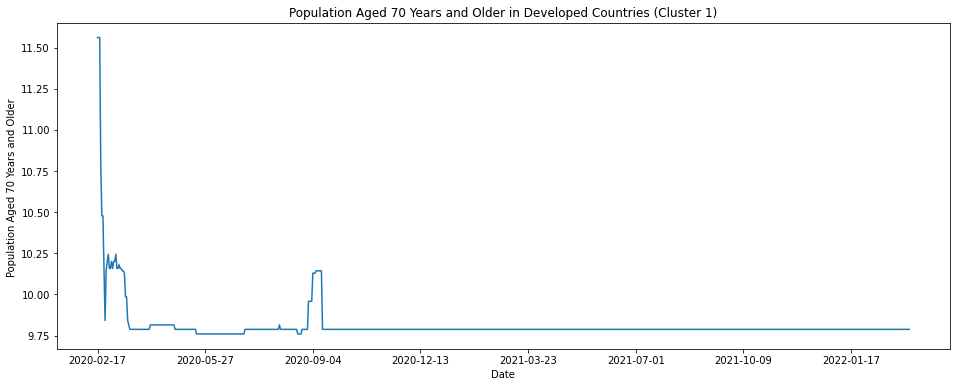

In [86]:
cluster1_yr_g = pd.DataFrame(data = cluster1_yr[["aged_70_older", "date"]].groupby(cluster1_yr["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_yr_g["aged_70_older"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Population Aged 70 Years and Older ")
plt.title("Population Aged 70 Years and Older in Developed Countries (Cluster 1)");

In [87]:
cluster2_yr = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_yr.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  retail_and_recreation  \
0                                      NaN                  1.000   
1                                      NaN                  0.857   
2                                      NaN                  0.857   
3                                      NaN                  1.000   
4                                      NaN                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  \
0                 6.286        0.286             6.143  2.714       6.000   
1                 6.286        0.429             6.143  2.429       6.143   
2                 6.571        0.429             6.571  2.571       6.143   
3                 6.143        0.571             6.429  2.857       6.286   
4                 5.571        0.857             6.000  2.429       6.143   

    Average  
0  3.738167  
1  3.714500  
2  3.857000  
3  3.881000  
4  3.619000  

[5 rows x 73 columns]

In [88]:
cluster2_yr.describe()[['aged_70_older']]

aged_70_older
count   40351.000000
mean        2.683079
std         1.209808
min         1.308000
25%         1.870000
50%         2.385000
75%         3.212000
max         6.955000

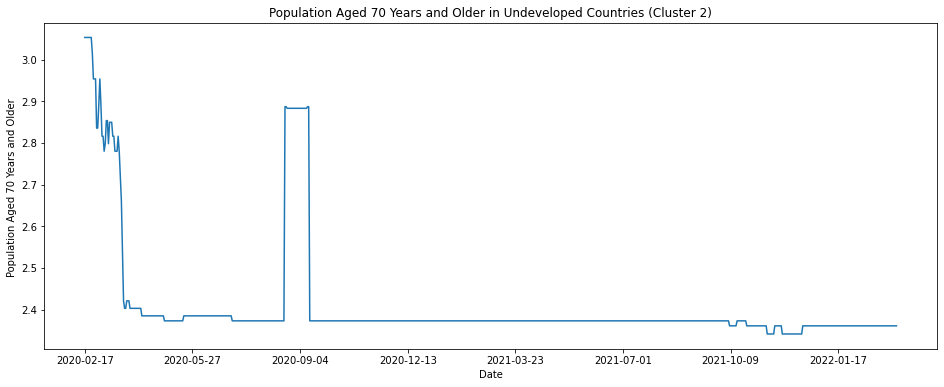

In [89]:
cluster2_yr_g = pd.DataFrame(data = cluster2_yr[["aged_70_older", "date"]].groupby(cluster2_yr["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_yr_g["aged_70_older"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Population Aged 70 Years and Older ")
plt.title("Population Aged 70 Years and Older in Undeveloped Countries (Cluster 2)");

# 5. Finding the best regression model for prediction
- Scale data using MinMaxScaler
- Run data in each cluster through different regression models (Linear Regression, Stochastic Gradient Descent, Decision Tree Regressor)

In [90]:
cluster1_regression = cluster1_data[relevant_columns]
cluster1_regression.head()

icu_patients_per_million  stringency_index  people_vaccinated_per_hundred  \
0                       NaN               NaN                            NaN   
1                       NaN               NaN                            NaN   
2                       NaN               NaN                            NaN   
3                       NaN               NaN                            NaN   
4                       NaN               NaN                            NaN   

   aged_70_older  cardiovasc_death_rate  retail_and_recreation  \
0          4.631                191.511                  1.429   
1          4.631                191.511                 -0.286   
2          4.631                191.511                 -2.429   
3          4.631                191.511                 -4.000   
4          4.631                191.511                 -7.429   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  
0                 8.286        0.500            -0.286  4.000       3.714  
1                 7.714        1.167            -2.571  2.714       2.857  
2                 7.143        1.167            -4.429 -0.571       1.714  
3                 5.857        2.500            -5.429 -1.857      -0.714  
4                 4.286        4.167            -8.000 -4.286      -3.429

In [91]:
cluster2_regression = cluster2_data[relevant_columns]
cluster2_regression.head()

icu_patients_per_million  stringency_index  people_vaccinated_per_hundred  \
0                       NaN              8.33                            NaN   
1                       NaN              8.33                            NaN   
2                       NaN              8.33                            NaN   
3                       NaN              8.33                            NaN   
4                       NaN              8.33                            NaN   

   aged_70_older  cardiovasc_death_rate  retail_and_recreation  \
0          1.337                597.029                  1.000   
1          1.337                597.029                  0.857   
2          1.337                597.029                  0.857   
3          1.337                597.029                  1.000   
4          1.337                597.029                  0.714   

   grocery_and_pharmacy  residential  transit_stations  parks  workplaces  
0                 6.286        0.286             6.143  2.714       6.000  
1                 6.286        0.429             6.143  2.429       6.143  
2                 6.571        0.429             6.571  2.571       6.143  
3                 6.143        0.571             6.429  2.857       6.286  
4                 5.571        0.857             6.000  2.429       6.143

In [92]:
scaler = MinMaxScaler()
cluster1_regression = cluster1_regression.fillna(0)
cluster1_regression = pd.DataFrame(scaler.fit_transform(cluster1_regression), columns = cluster1_regression.columns)
cluster1_regression.head()

icu_patients_per_million  stringency_index  people_vaccinated_per_hundred  \
0                       0.0               0.0                            0.0   
1                       0.0               0.0                            0.0   
2                       0.0               0.0                            0.0   
3                       0.0               0.0                            0.0   
4                       0.0               0.0                            0.0   

   aged_70_older  cardiovasc_death_rate  retail_and_recreation  \
0       0.250419               0.385941               0.601477   
1       0.250419               0.385941               0.590403   
2       0.250419               0.385941               0.576564   
3       0.250419               0.385941               0.566419   
4       0.250419               0.385941               0.544276   

   grocery_and_pharmacy  residential  transit_stations     parks  workplaces  
0              0.519188     0.275129          0.551246  0.140514    0.735505  
1              0.516053     0.286860          0.537469  0.138646    0.728260  
2              0.512923     0.286860          0.526267  0.133873    0.718597  
3              0.505874     0.310305          0.520237  0.132005    0.698071  
4              0.497262     0.339624          0.504736  0.128476    0.675118

<AxesSubplot:>

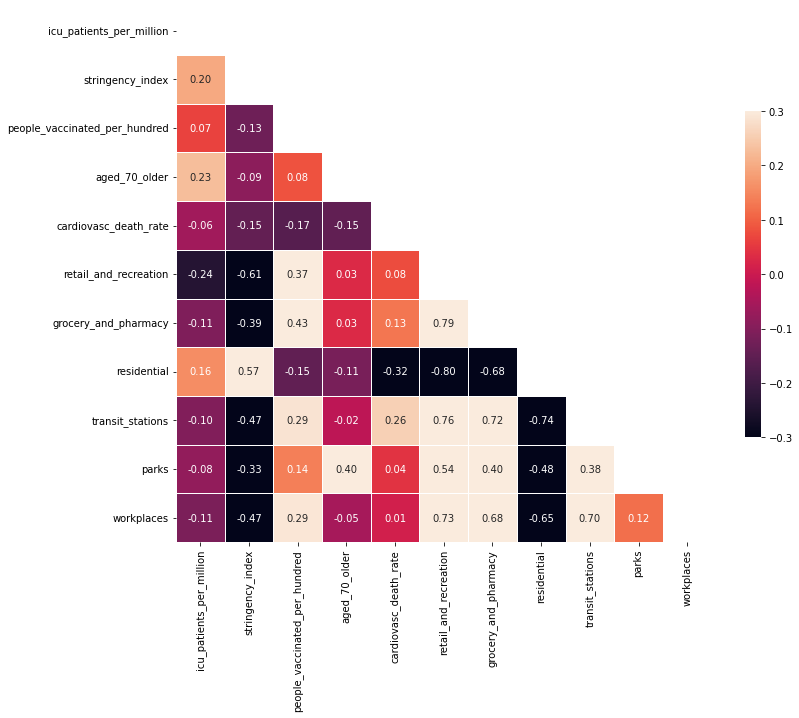

In [93]:
var_corr1 = cluster1_regression.corr()

mask = np.triu(np.ones_like(var_corr1, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

sb.heatmap(var_corr1, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

In [94]:
scaler = MinMaxScaler()
cluster2_regression = cluster2_regression.fillna(0)
cluster2_regression = pd.DataFrame(scaler.fit_transform(cluster2_regression), columns = cluster2_regression.columns)
cluster2_regression.head()

icu_patients_per_million  stringency_index  people_vaccinated_per_hundred  \
0                       0.0            0.0833                            0.0   
1                       0.0            0.0833                            0.0   
2                       0.0            0.0833                            0.0   
3                       0.0            0.0833                            0.0   
4                       0.0            0.0833                            0.0   

   aged_70_older  cardiovasc_death_rate  retail_and_recreation  \
0       0.005135                    1.0               0.339480   
1       0.005135                    1.0               0.338938   
2       0.005135                    1.0               0.338938   
3       0.005135                    1.0               0.339480   
4       0.005135                    1.0               0.338395   

   grocery_and_pharmacy  residential  transit_stations     parks  workplaces  
0              0.298363     0.355897          0.399173  0.248343    0.447032  
1              0.298363     0.358083          0.399173  0.247565    0.447784  
2              0.299246     0.358083          0.400945  0.247953    0.447784  
3              0.297920     0.360253          0.400357  0.248733    0.448536  
4              0.296148     0.364624          0.398581  0.247565    0.447784

<AxesSubplot:>

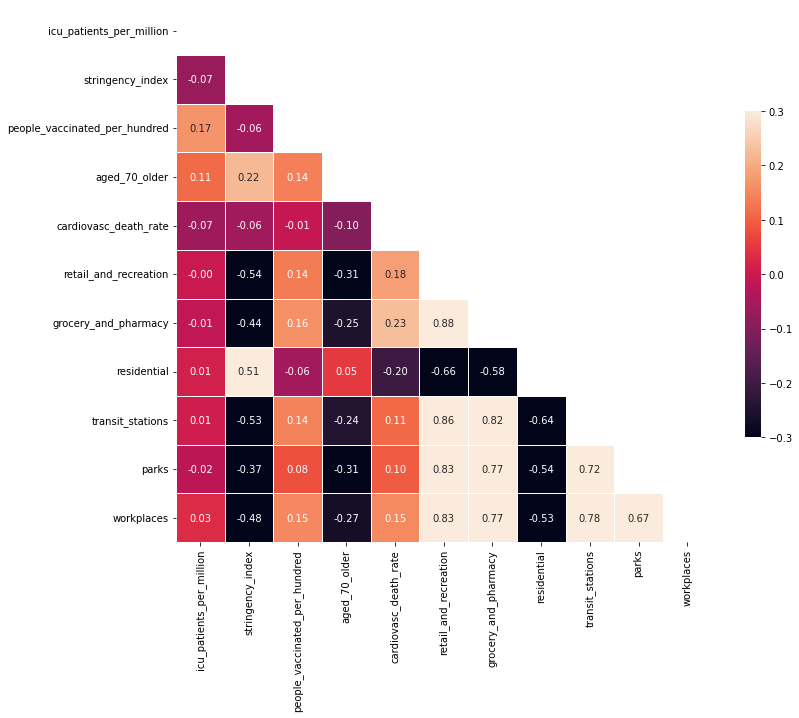

In [95]:
var_corr2 = cluster2_regression.corr()

mask = np.triu(np.ones_like(var_corr2, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

sb.heatmap(var_corr2, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

From the heatmap we can observe that each variable affect mobility with a slight difference in both clusters

In [96]:
y_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']
x_data = cluster1_regression.drop(y_columns, axis=1)
x_columns = x_data.columns.tolist()
print(x_columns)

['icu_patients_per_million', 'stringency_index', 'people_vaccinated_per_hundred', 'aged_70_older', 'cardiovasc_death_rate']


In [97]:
def regression_fit_plot(x, y):
    plt.figure(figsize = (20,5))

    plt.subplot(1, 3, 1)
    plt.scatter(x, y, alpha = 0.1)
    plt.plot(x, x, color = "blue", linewidth = 1)
    plt.title("Regression Fit")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def lin_r(regression_data, x_columns, y_columns):
    model = LinearRegression()
    x = regression_data[x_columns]
    for i in range(len(y_columns)):
        y = regression_data[y_columns[i]]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
        model.fit(x_train, y_train)
        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print(y_columns[i])
        f, axes = plt.subplots(1, 3, figsize=(24, 6))
        sb.boxplot(data = y_train, orient = "h", ax = axes[0])
        sb.histplot(data = y_train, ax = axes[1])
        sb.violinplot(data = y_train, orient = "h", ax = axes[2])
        plt.show()
        regression_fit_plot(y_prediction, y_test)
        print("Explained Variance (R^2) \t:", score)
        print("Mean Squared Error (MSE) \t:",mean_squared_error(y_test,y_prediction))
        print("Root-Mean-Squared Error \t:",np.sqrt(mean_squared_error(y_test,y_prediction)))
        print()
        
def dt_r(regression_data, x_columns, y_columns):
    model = tree.DecisionTreeRegressor()
    x = regression_data[x_columns]
    for i in range(len(y_columns)):
        y = regression_data[y_columns[i]]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
        model.fit(x_train, y_train)
        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print(y_columns[i])
        f, axes = plt.subplots(1, 3, figsize=(24, 6))
        sb.boxplot(data = y_train, orient = "h", ax = axes[0])
        sb.histplot(data = y_train, ax = axes[1])
        sb.violinplot(data = y_train, orient = "h", ax = axes[2])
        plt.show()
        regression_fit_plot(y_prediction, y_test)
        print("Explained Variance (R^2) \t:", score)
        print("Mean Squared Error (MSE) \t:",mean_squared_error(y_test,y_prediction))
        print("Root-Mean-Squared Error \t:",np.sqrt(mean_squared_error(y_test,y_prediction)))
        print()

def sgd_r(regression_data, x_columns, y_columns):
    model = SGDRegressor()
    x = regression_data[x_columns]
    for i in range(len(y_columns)):
        y = regression_data[y_columns[i]]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
        model.fit(x_train, y_train)
        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print(y_columns[i])
        f, axes = plt.subplots(1, 3, figsize=(24, 6))
        sb.boxplot(data = y_train, orient = "h", ax = axes[0])
        sb.histplot(data = y_train, ax = axes[1])
        sb.violinplot(data = y_train, orient = "h", ax = axes[2])
        plt.show()
        regression_fit_plot(y_prediction, y_test)
        print("Explained Variance (R^2) \t:", score)
        print("Mean Squared Error (MSE) \t:",mean_squared_error(y_test,y_prediction))
        print("Root-Mean-Squared Error \t:",np.sqrt(mean_squared_error(y_test,y_prediction)))
        print()

## 5.1. Linear Regression

Cluster 1: Linear Regression

retail_and_recreation


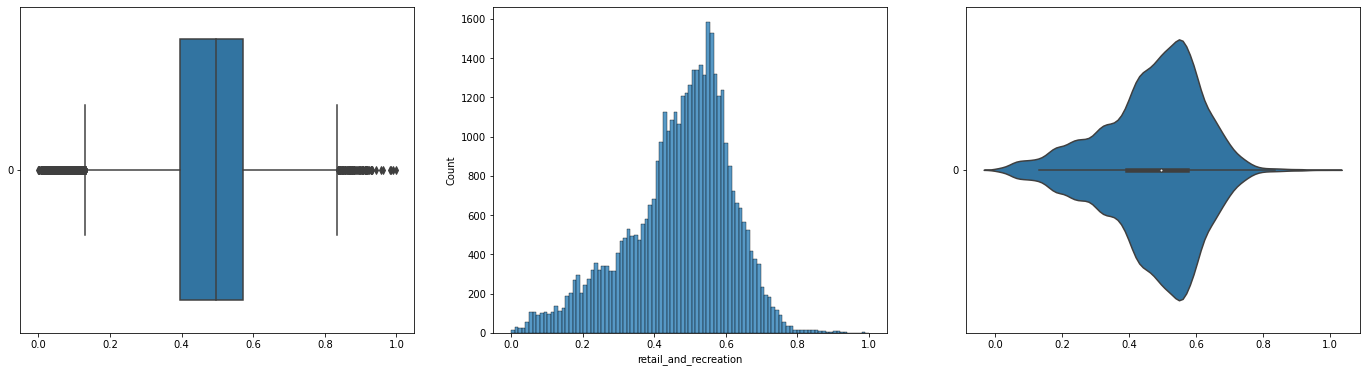

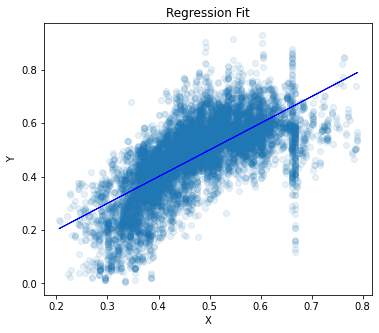

Explained Variance (R^2) 	: 0.4756140334051444
Mean Squared Error (MSE) 	: 0.010813917358784014
Root-Mean-Squared Error 	: 0.10398998681980882

grocery_and_pharmacy


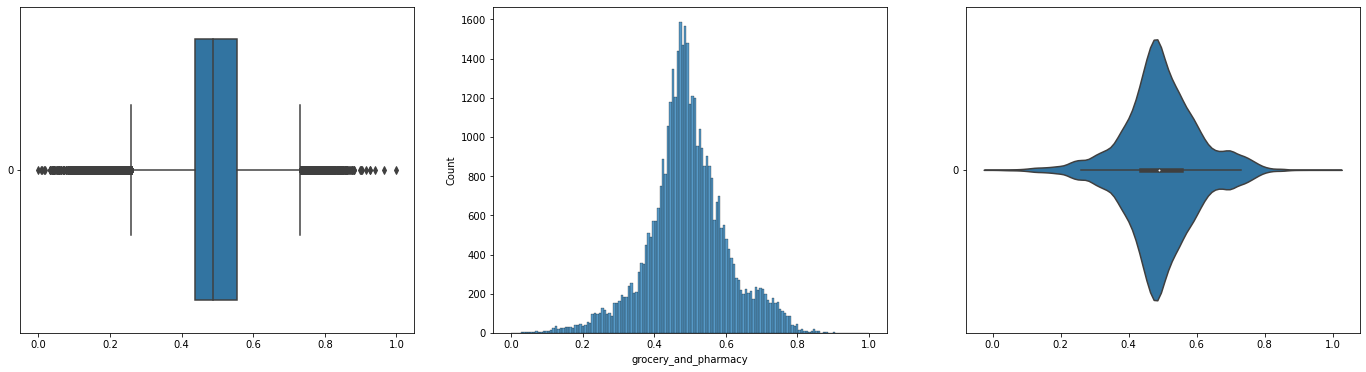

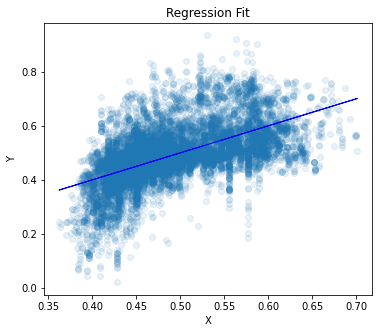

Explained Variance (R^2) 	: 0.3090538470937071
Mean Squared Error (MSE) 	: 0.008306739631962401
Root-Mean-Squared Error 	: 0.09114131682152941

residential


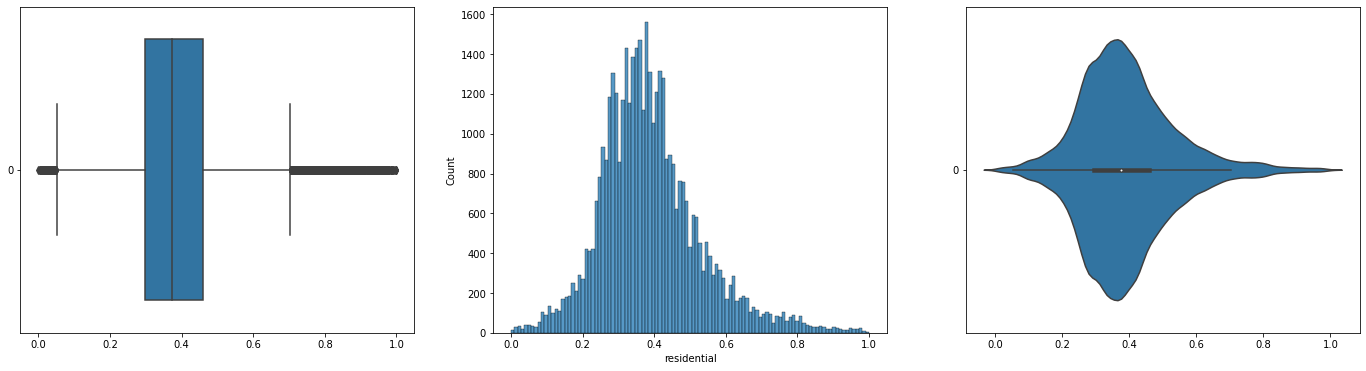

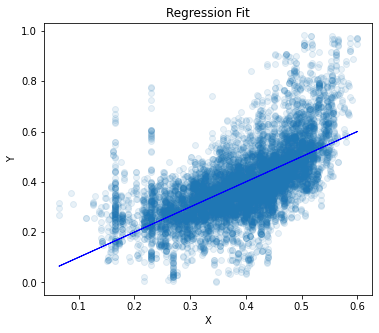

Explained Variance (R^2) 	: 0.4193627675465279
Mean Squared Error (MSE) 	: 0.011340524795806311
Root-Mean-Squared Error 	: 0.1064919001417775

transit_stations


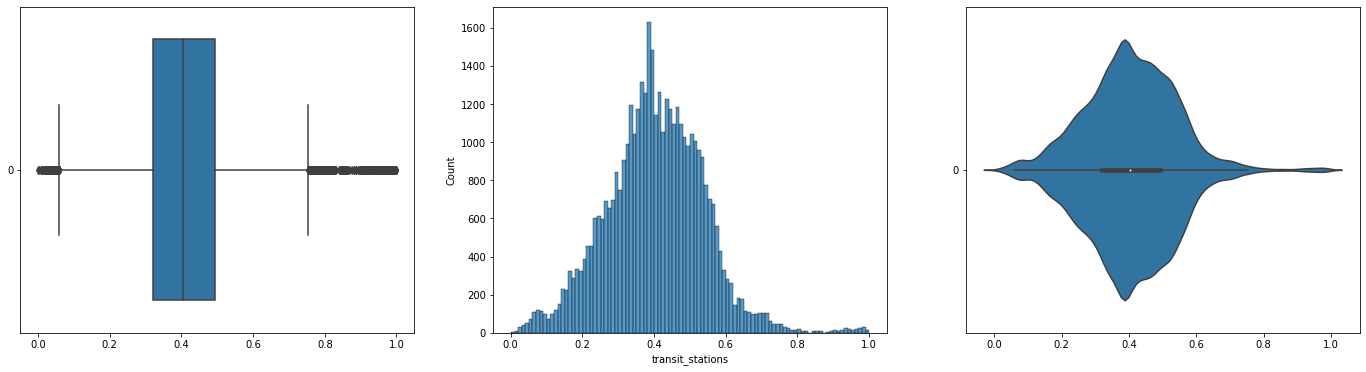

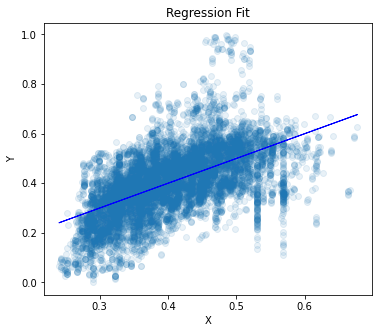

Explained Variance (R^2) 	: 0.324305728839012
Mean Squared Error (MSE) 	: 0.012313595304521838
Root-Mean-Squared Error 	: 0.11096664050299909

parks


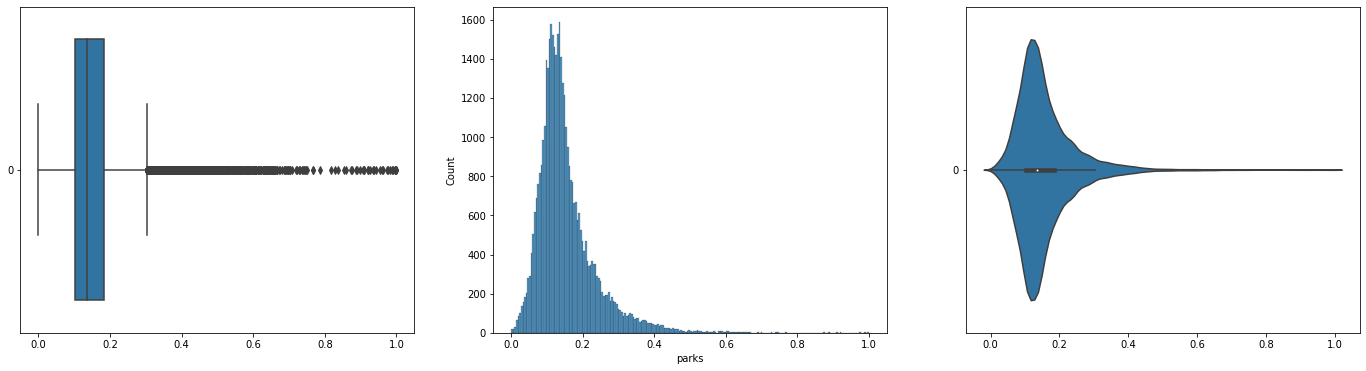

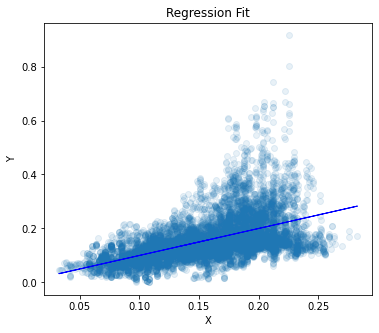

Explained Variance (R^2) 	: 0.2801078304063457
Mean Squared Error (MSE) 	: 0.004933372575905362
Root-Mean-Squared Error 	: 0.070237971040637

workplaces


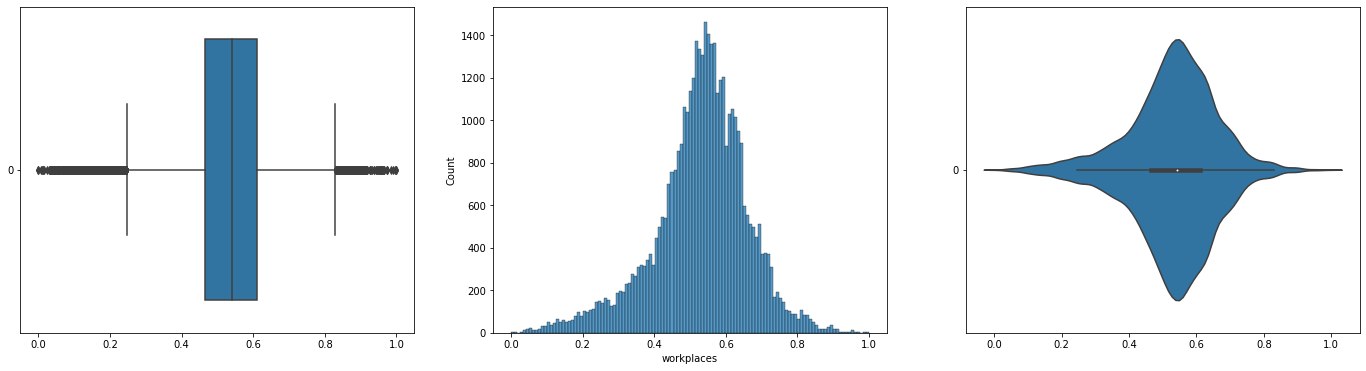

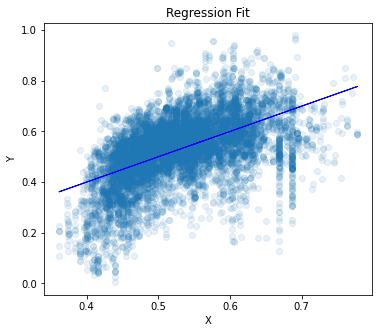

Explained Variance (R^2) 	: 0.27823138381944235
Mean Squared Error (MSE) 	: 0.01202307159336112
Root-Mean-Squared Error 	: 0.10964976786733806



In [98]:
print("Cluster 1: Linear Regression\n")
lin_r(cluster1_regression, x_columns, y_columns)

Cluster 2: Linear Regression

retail_and_recreation


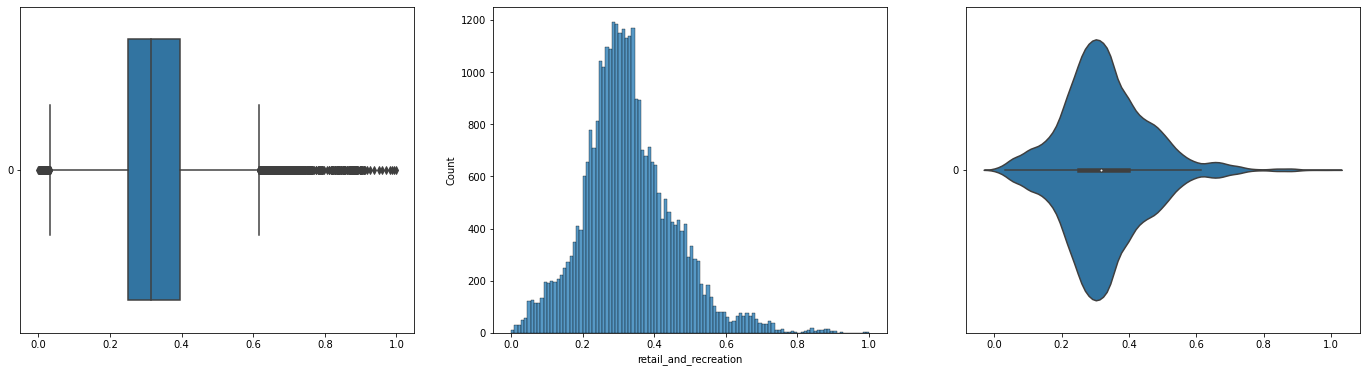

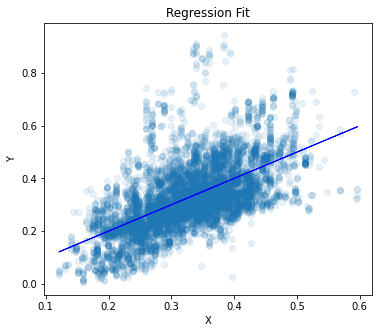

Explained Variance (R^2) 	: 0.3553663742452231
Mean Squared Error (MSE) 	: 0.010418489315622864
Root-Mean-Squared Error 	: 0.1020710013452541

grocery_and_pharmacy


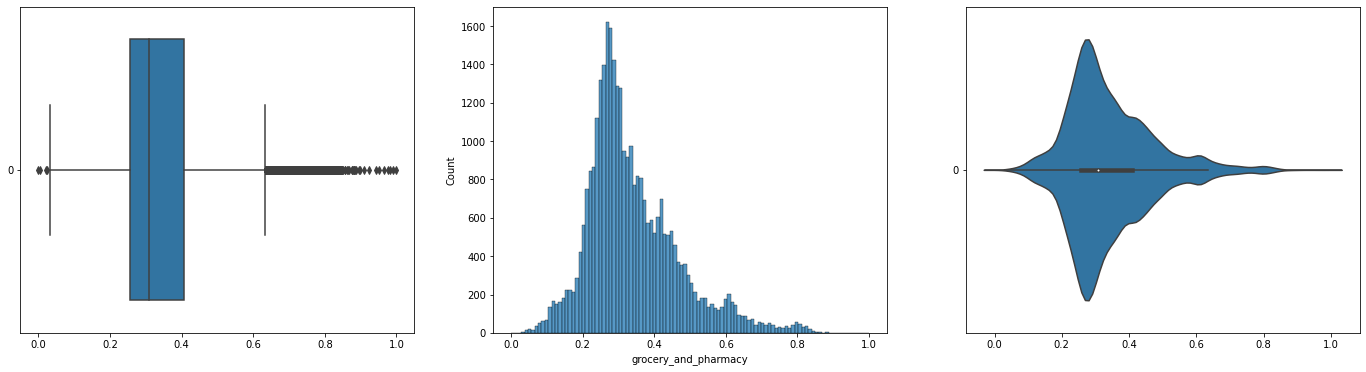

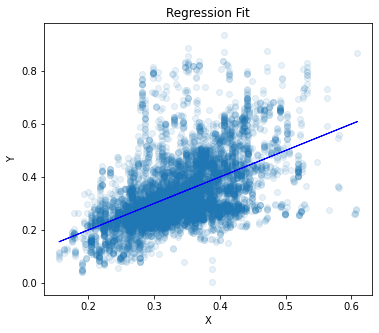

Explained Variance (R^2) 	: 0.2785544299602185
Mean Squared Error (MSE) 	: 0.011904255545756371
Root-Mean-Squared Error 	: 0.10910662466484962

residential


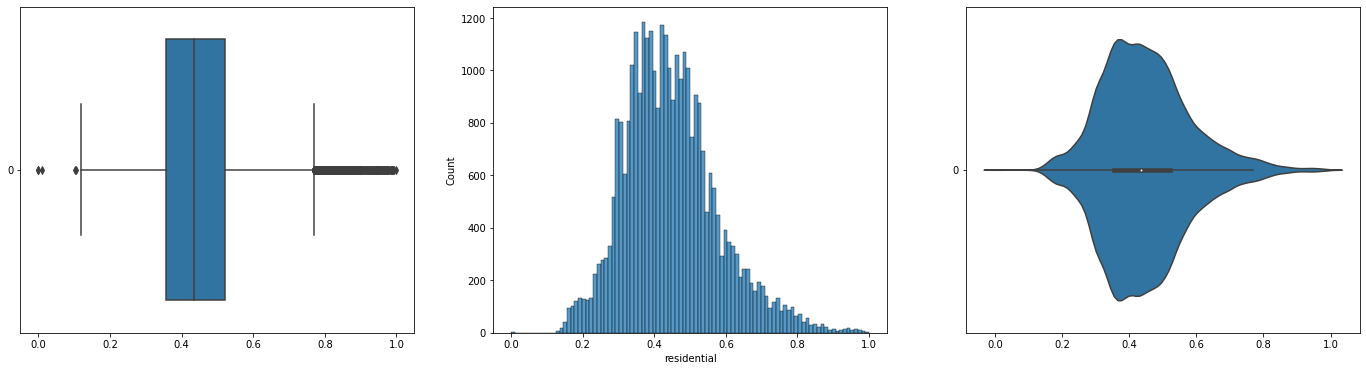

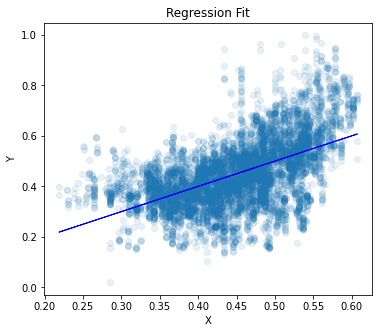

Explained Variance (R^2) 	: 0.30213056855706033
Mean Squared Error (MSE) 	: 0.012167526062503079
Root-Mean-Squared Error 	: 0.11030650961073457

transit_stations


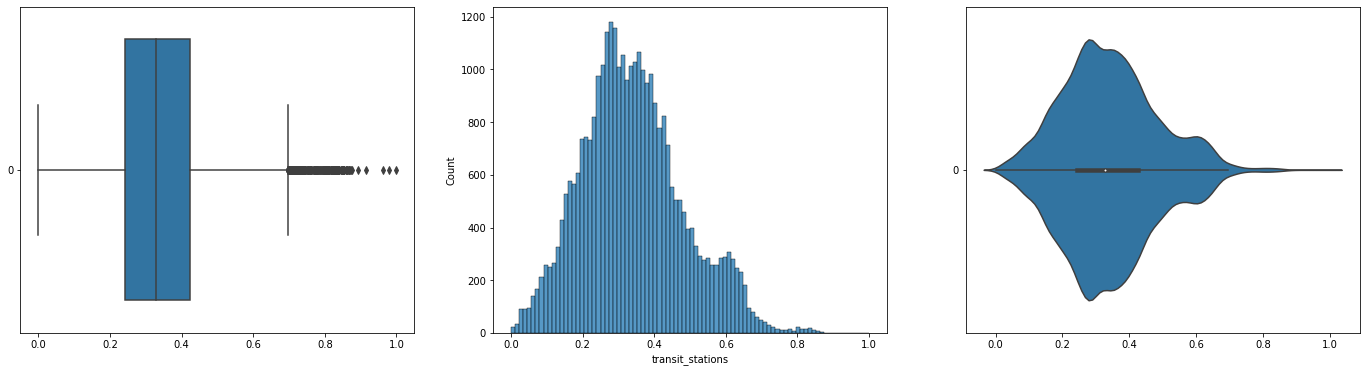

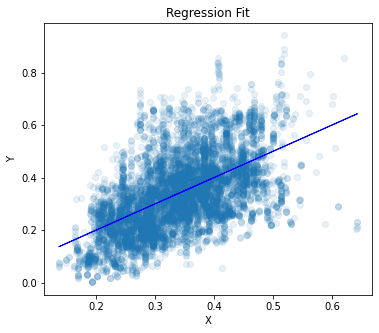

Explained Variance (R^2) 	: 0.3115296584237419
Mean Squared Error (MSE) 	: 0.013603246123386488
Root-Mean-Squared Error 	: 0.11663295470571981

parks


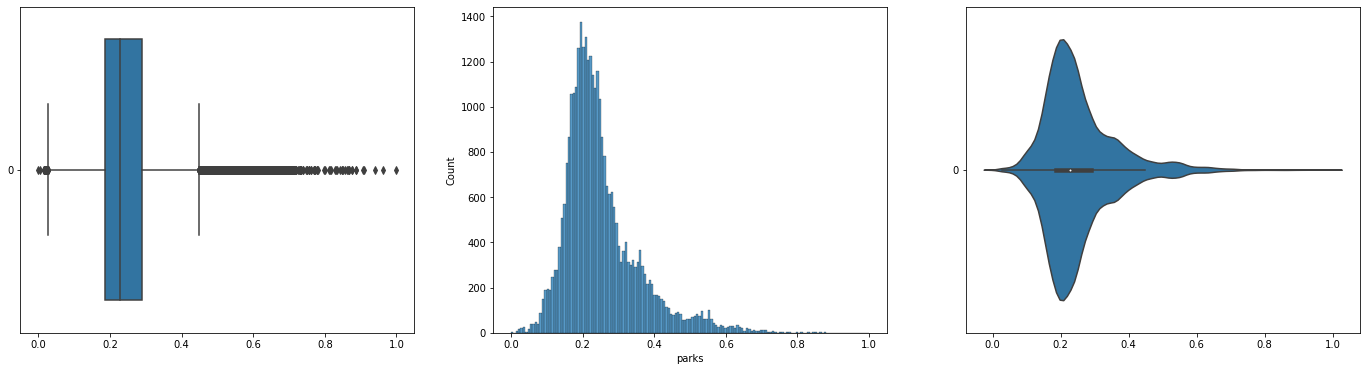

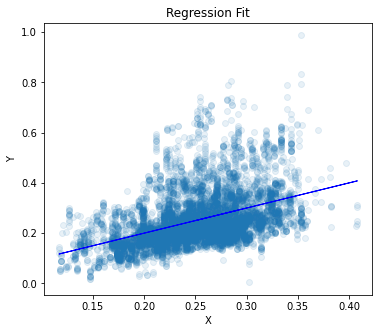

Explained Variance (R^2) 	: 0.1883855020023798
Mean Squared Error (MSE) 	: 0.00883061709955831
Root-Mean-Squared Error 	: 0.0939713631887838

workplaces


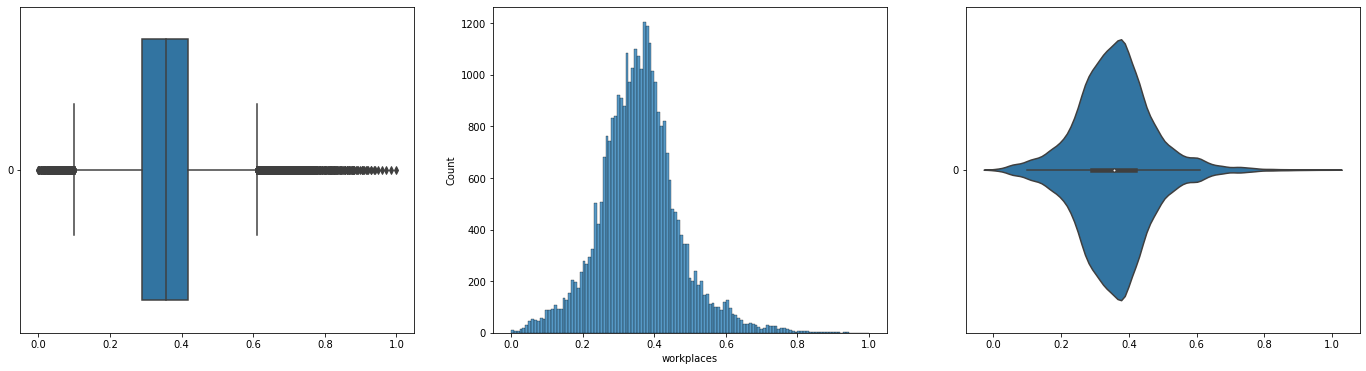

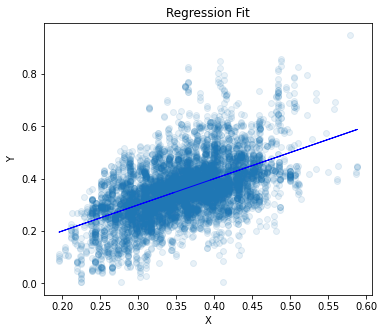

Explained Variance (R^2) 	: 0.2943877043892401
Mean Squared Error (MSE) 	: 0.008561045307611788
Root-Mean-Squared Error 	: 0.09252591695093752



In [99]:
print("Cluster 2: Linear Regression\n")
lin_r(cluster2_regression, x_columns, y_columns)

#### Boxplot shows that there are extreme variance among data but these data should not be removed due to COVID-19.

#### Multi-Variate Linear Regression scored low (less than 50% accuracy in most mobility) hence we should try out other regression model.

## 5.2. Stochastic Gradient Descent (SGD) Regressor

Cluster 1: Stochastic Gradient Descent (SGD) Regressor

retail_and_recreation


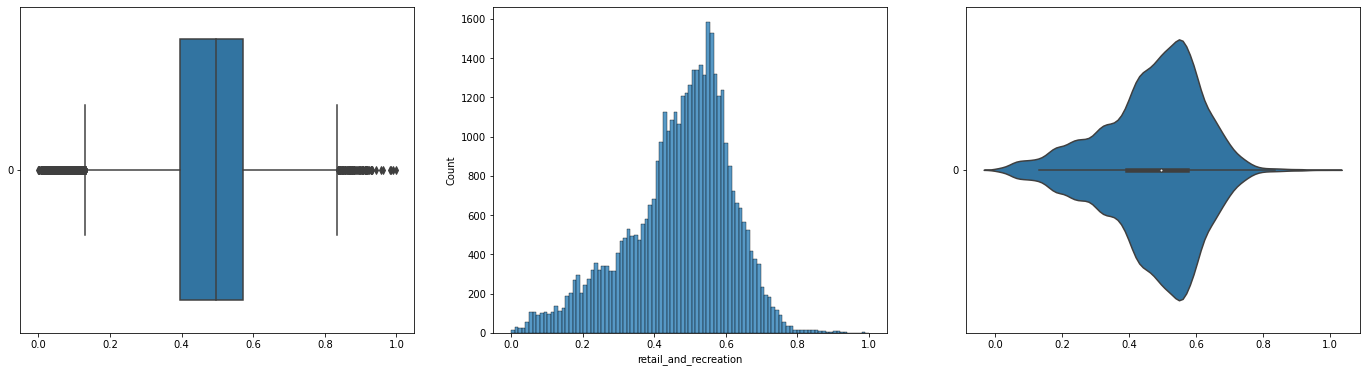

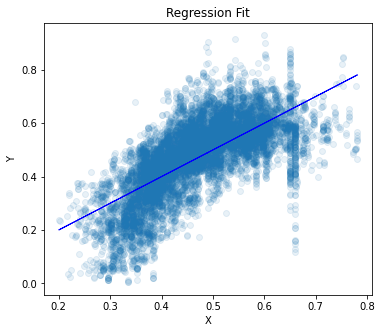

Explained Variance (R^2) 	: 0.4743159036228838
Mean Squared Error (MSE) 	: 0.010840687465309744
Root-Mean-Squared Error 	: 0.10411862208706829

grocery_and_pharmacy


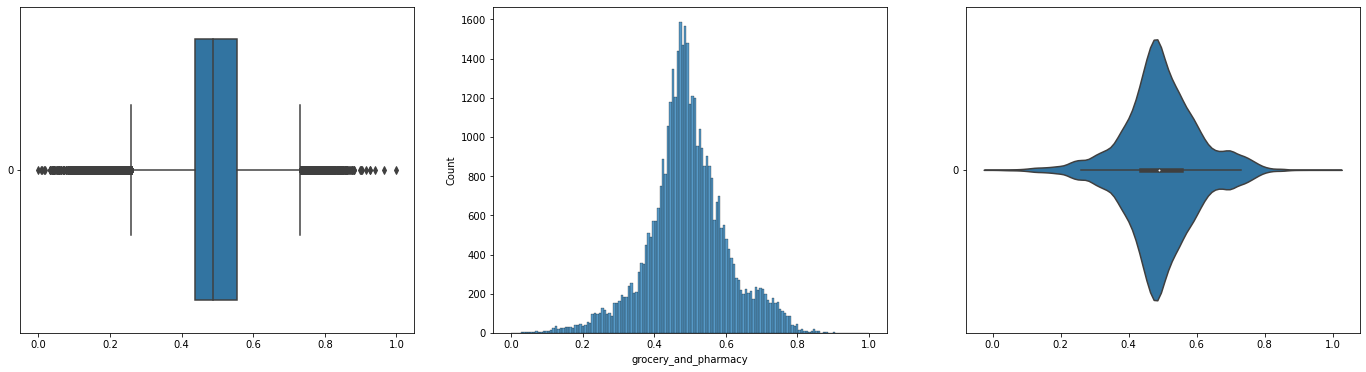

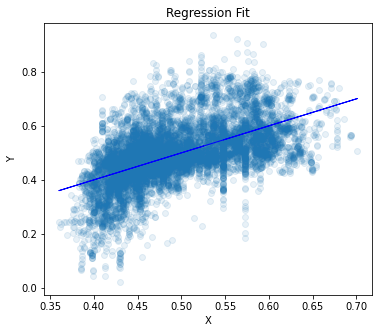

Explained Variance (R^2) 	: 0.30820768926836684
Mean Squared Error (MSE) 	: 0.008316912367873996
Root-Mean-Squared Error 	: 0.09119710723413324

residential


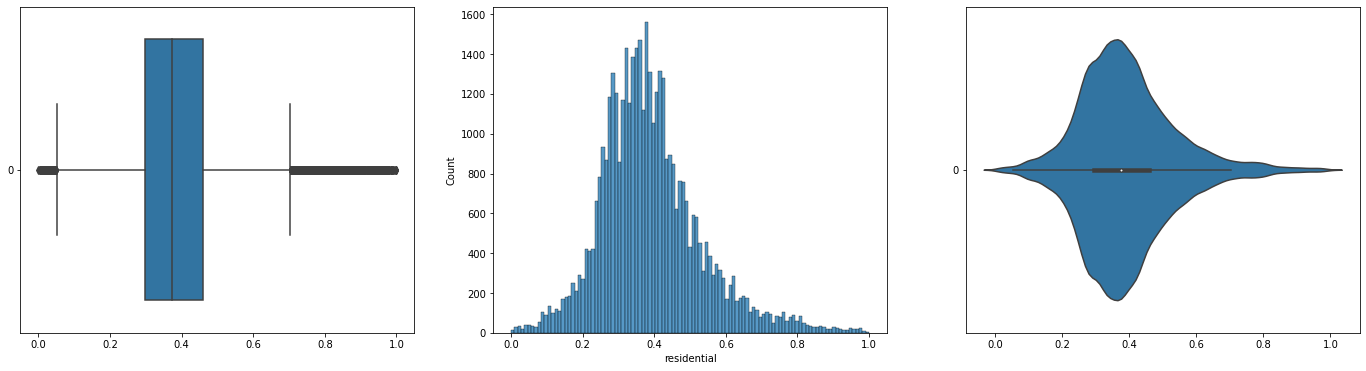

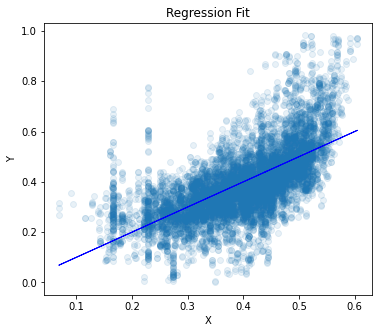

Explained Variance (R^2) 	: 0.41859916927615304
Mean Squared Error (MSE) 	: 0.011355438763831804
Root-Mean-Squared Error 	: 0.1065619010896099

transit_stations


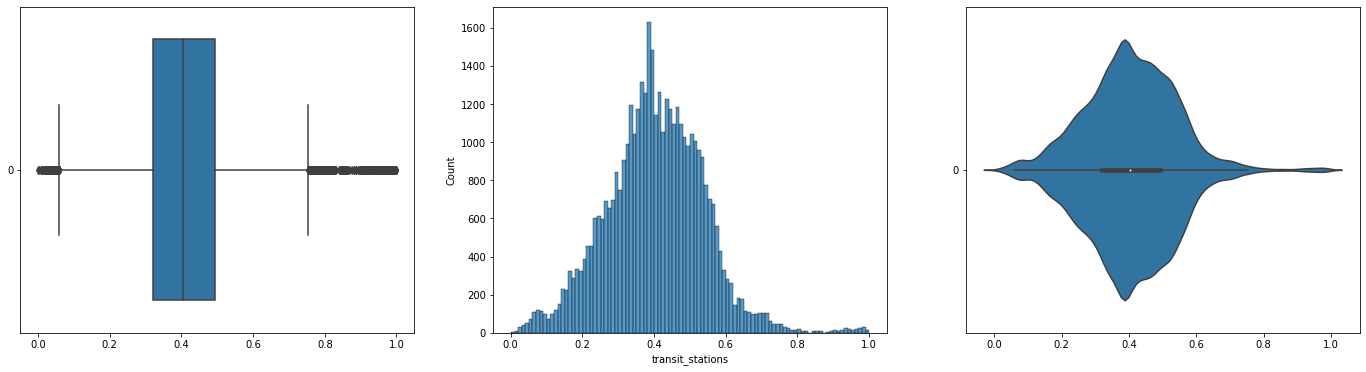

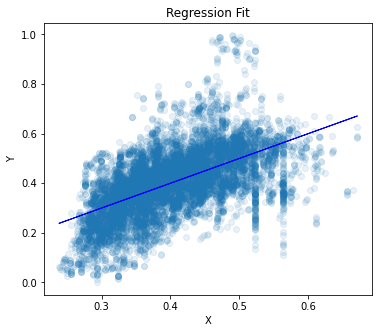

Explained Variance (R^2) 	: 0.3236906536268359
Mean Squared Error (MSE) 	: 0.012324804201160205
Root-Mean-Squared Error 	: 0.11101713471874602

parks


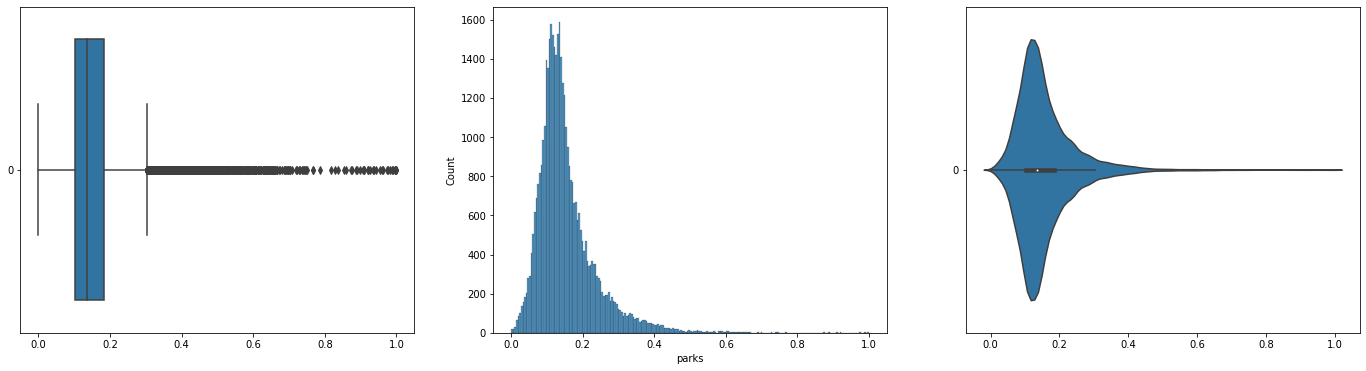

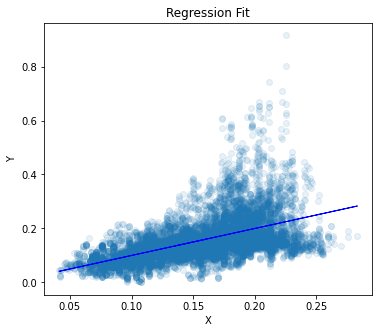

Explained Variance (R^2) 	: 0.28010911226098756
Mean Squared Error (MSE) 	: 0.004933363791441794
Root-Mean-Squared Error 	: 0.07023790850702911

workplaces


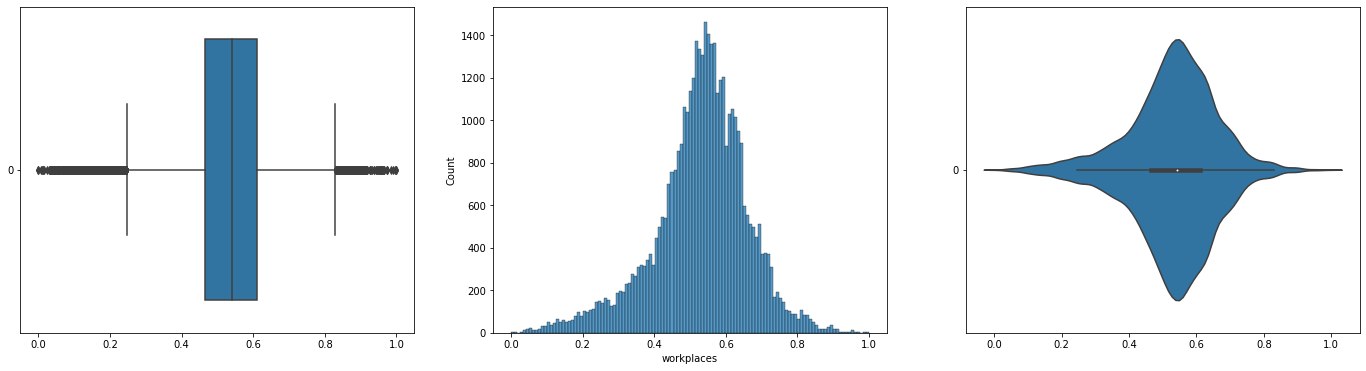

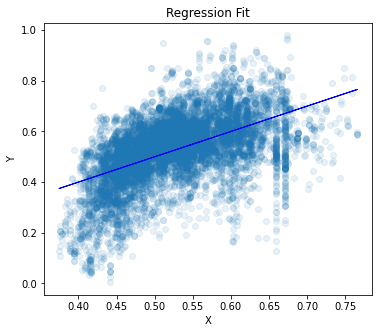

Explained Variance (R^2) 	: 0.2768726006703839
Mean Squared Error (MSE) 	: 0.01204570592064378
Root-Mean-Squared Error 	: 0.10975293126219354



In [100]:
print("Cluster 1: Stochastic Gradient Descent (SGD) Regressor\n")
sgd_r(cluster1_regression, x_columns, y_columns)

Cluster 2: Stochastic Gradient Descent (SGD) Regressor

retail_and_recreation


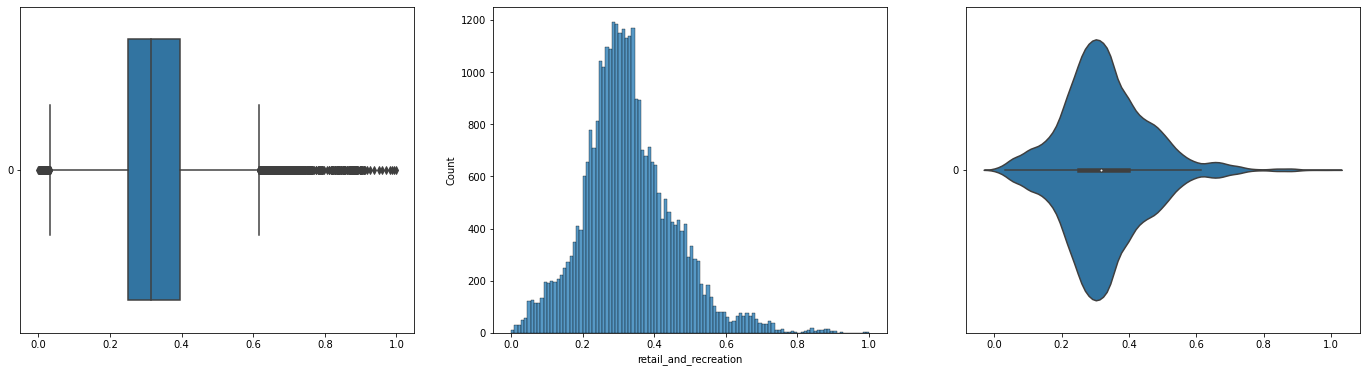

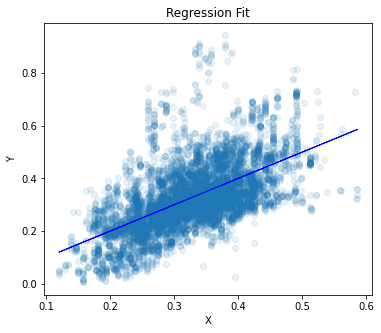

Explained Variance (R^2) 	: 0.3559070007421865
Mean Squared Error (MSE) 	: 0.010409751776721194
Root-Mean-Squared Error 	: 0.1020281910881556

grocery_and_pharmacy


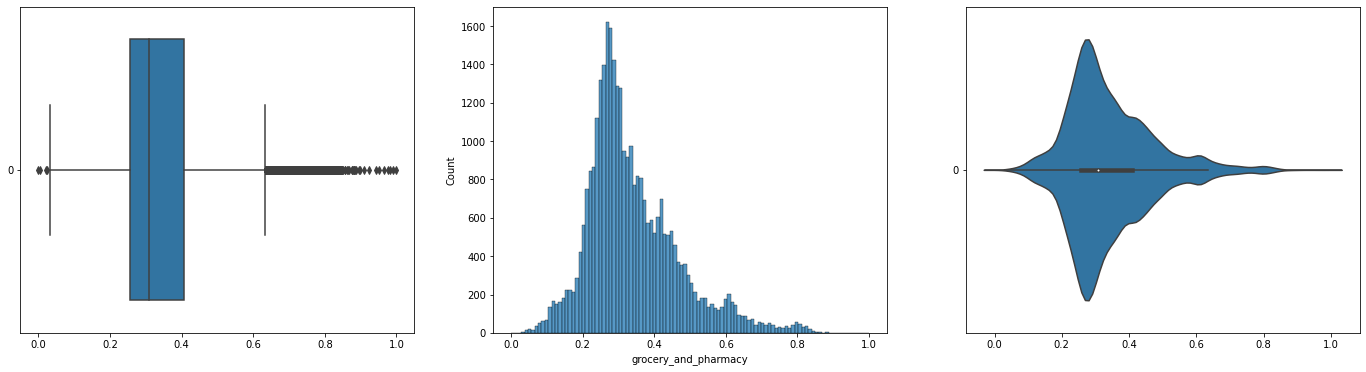

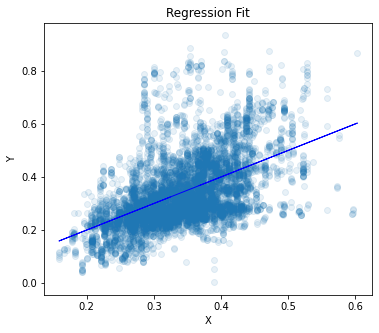

Explained Variance (R^2) 	: 0.27783320378348
Mean Squared Error (MSE) 	: 0.01191615618118991
Root-Mean-Squared Error 	: 0.1091611477641652

residential


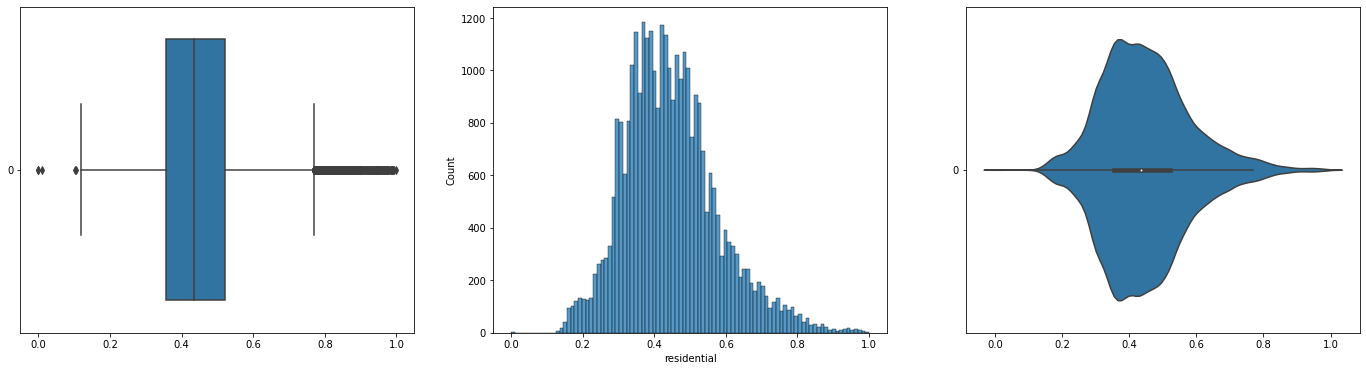

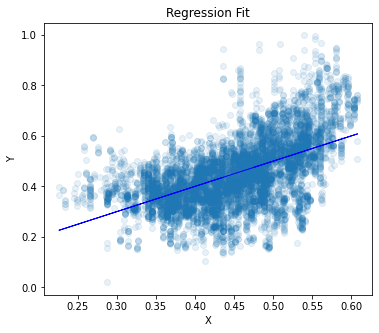

Explained Variance (R^2) 	: 0.3014215140665296
Mean Squared Error (MSE) 	: 0.012179888602835916
Root-Mean-Squared Error 	: 0.11036253260430333

transit_stations


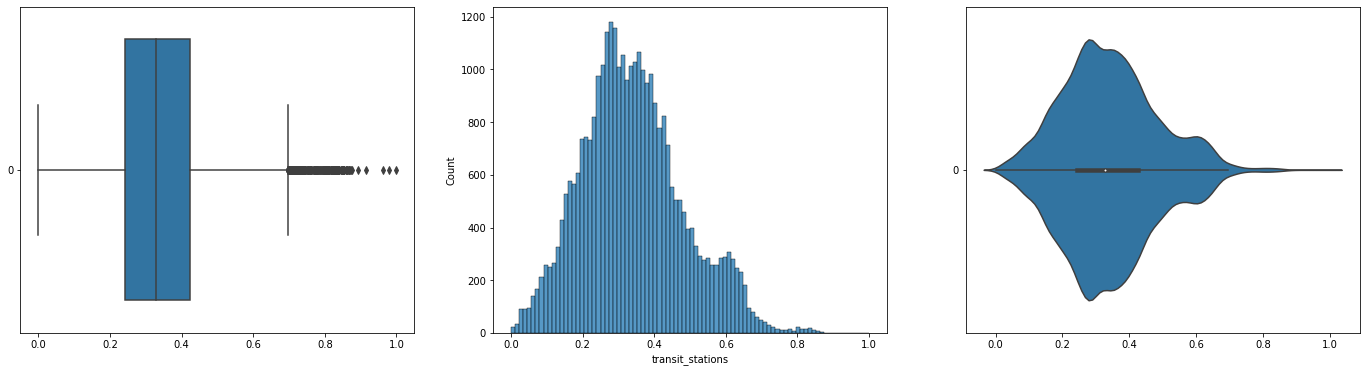

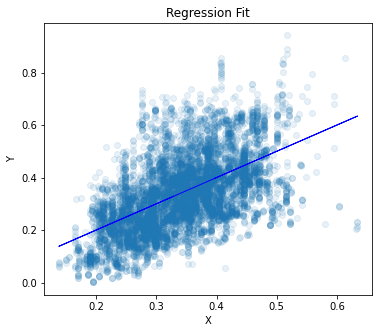

Explained Variance (R^2) 	: 0.31158607707626507
Mean Squared Error (MSE) 	: 0.013602131366845974
Root-Mean-Squared Error 	: 0.11662817569886778

parks


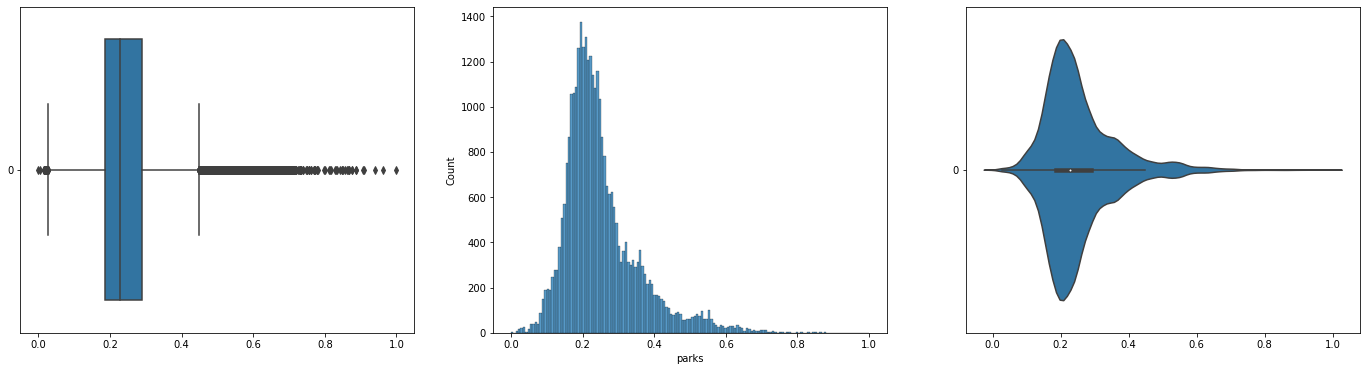

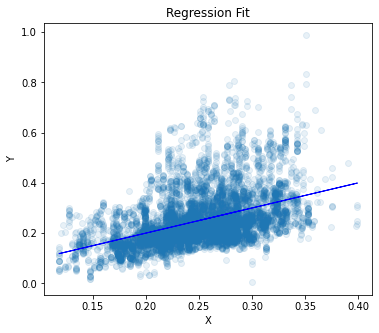

Explained Variance (R^2) 	: 0.18885236694274354
Mean Squared Error (MSE) 	: 0.008825537464416586
Root-Mean-Squared Error 	: 0.09394433173117252

workplaces


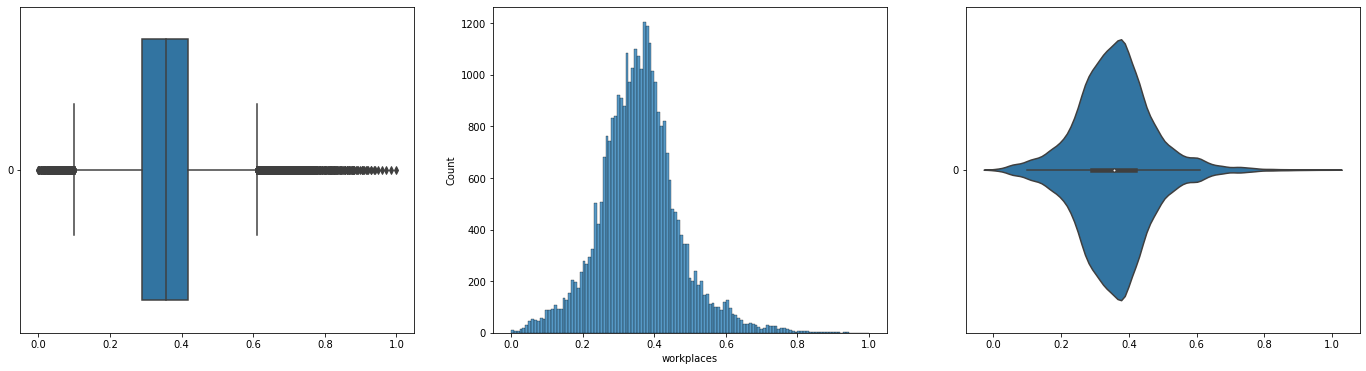

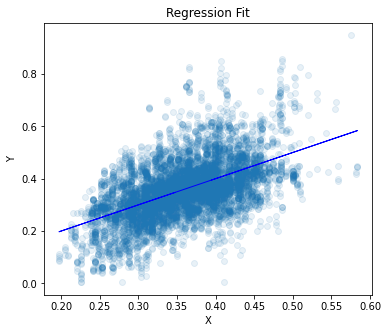

Explained Variance (R^2) 	: 0.29471243970994676
Mean Squared Error (MSE) 	: 0.008557105362388549
Root-Mean-Squared Error 	: 0.09250462346493038



In [101]:
print("Cluster 2: Stochastic Gradient Descent (SGD) Regressor\n")
sgd_r(cluster2_regression, x_columns, y_columns)

#### Similar to Linear Regression, SGD regressor scored poorly on the accuracy as well. We should try out another model.

## 5.3. Decision Tree Regressor

Cluster 1: Decision Tree Regressor

retail_and_recreation


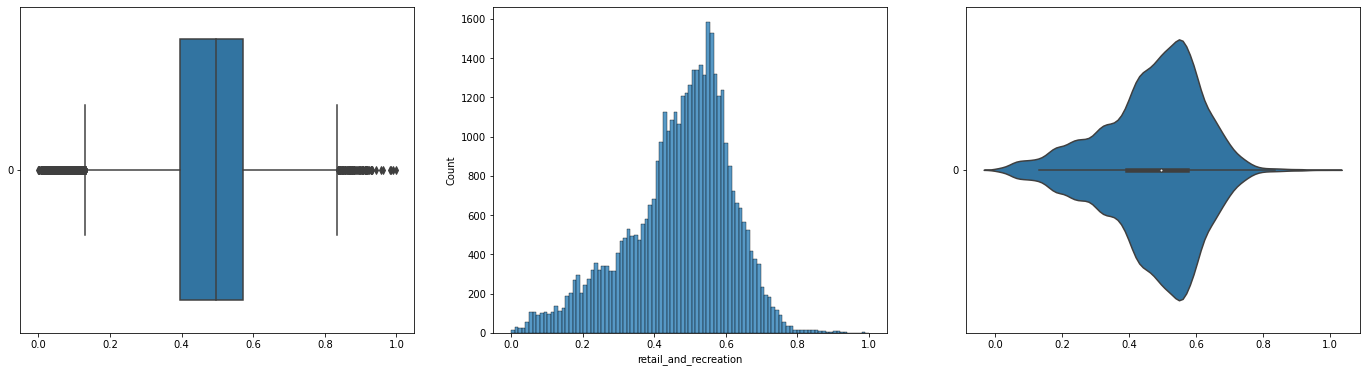

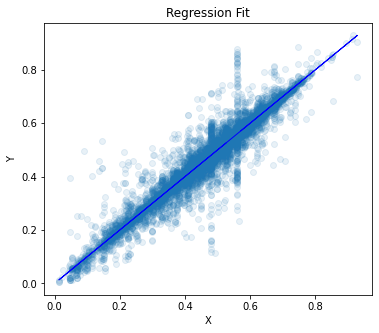

Explained Variance (R^2) 	: 0.9190196991366696
Mean Squared Error (MSE) 	: 0.0016699803904212868
Root-Mean-Squared Error 	: 0.04086539355519884

grocery_and_pharmacy


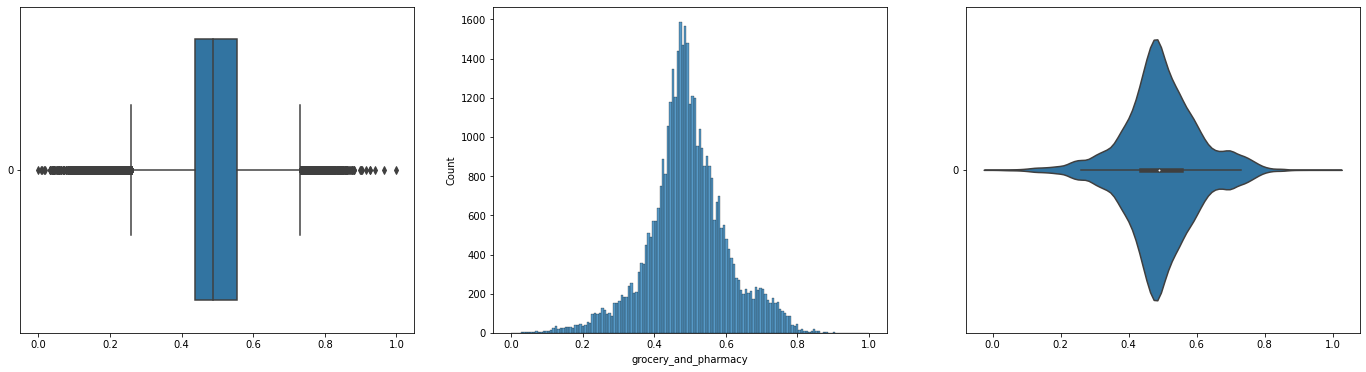

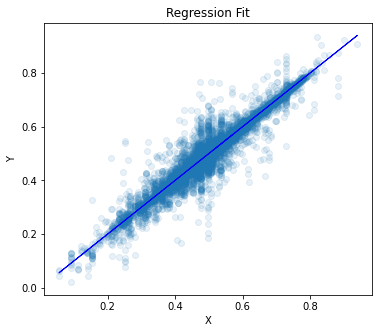

Explained Variance (R^2) 	: 0.9134824369899823
Mean Squared Error (MSE) 	: 0.0010401373051911124
Root-Mean-Squared Error 	: 0.03225115974955184

residential


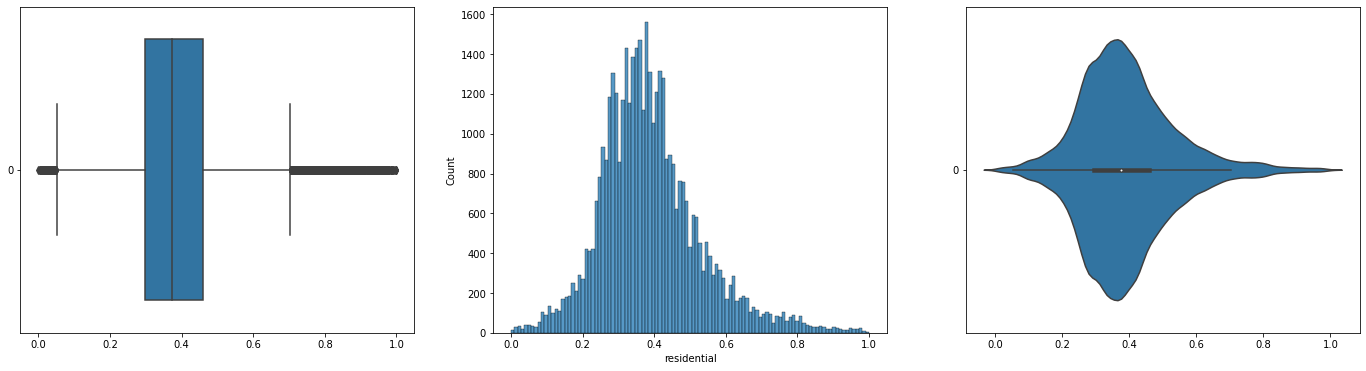

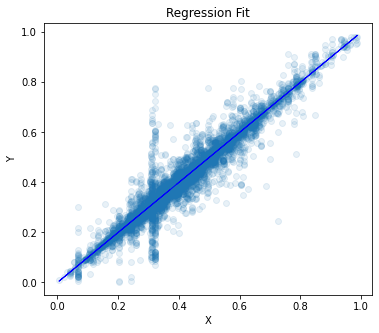

Explained Variance (R^2) 	: 0.9212351020761319
Mean Squared Error (MSE) 	: 0.0015383706521375305
Root-Mean-Squared Error 	: 0.039222068432676144

transit_stations


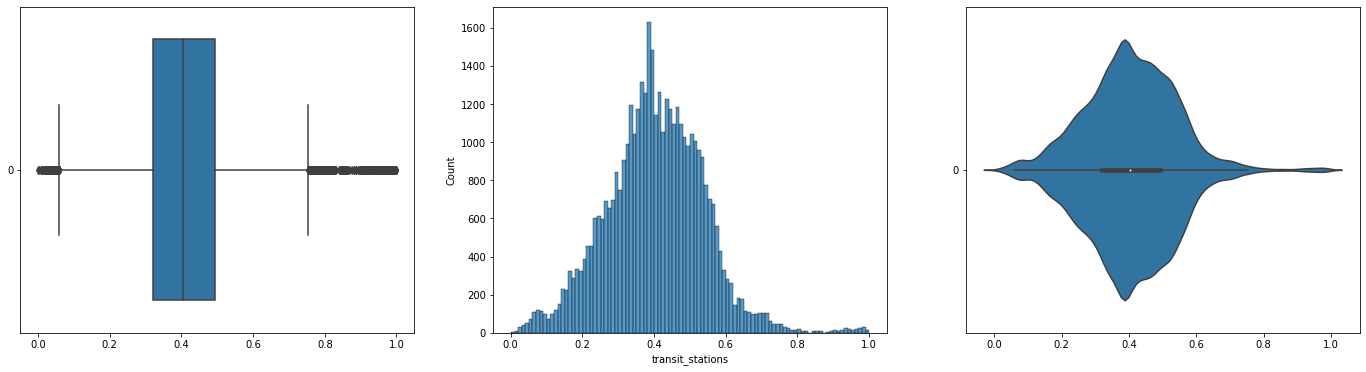

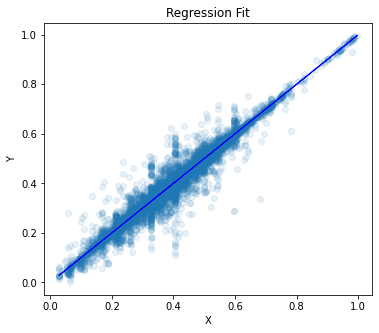

Explained Variance (R^2) 	: 0.9447526789522956
Mean Squared Error (MSE) 	: 0.0010068061578671263
Root-Mean-Squared Error 	: 0.03173020891622251

parks


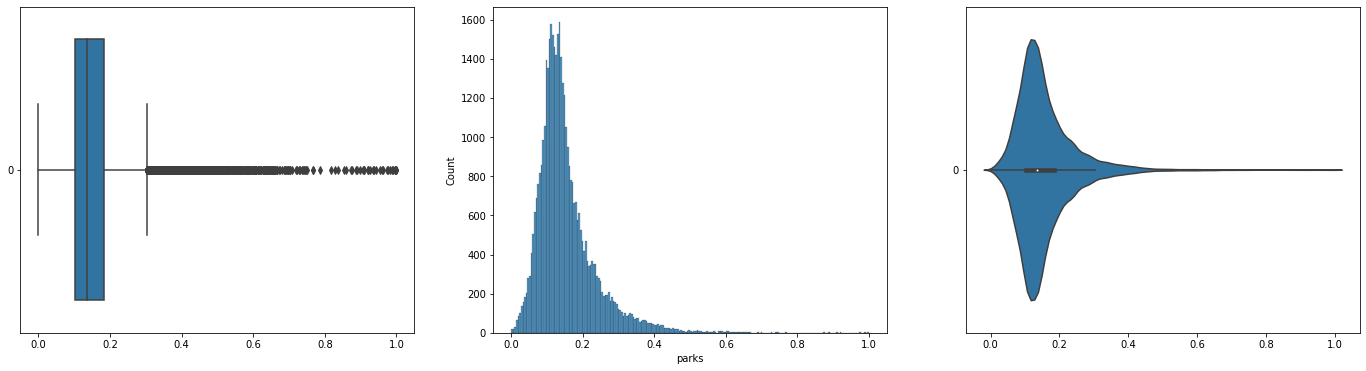

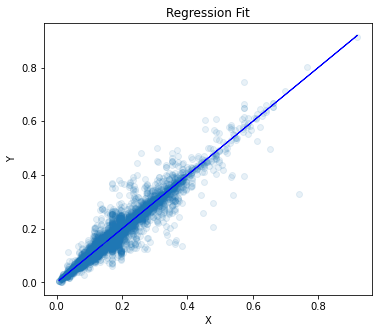

Explained Variance (R^2) 	: 0.9270535290515379
Mean Squared Error (MSE) 	: 0.0004998972547365682
Root-Mean-Squared Error 	: 0.02235838220302552

workplaces


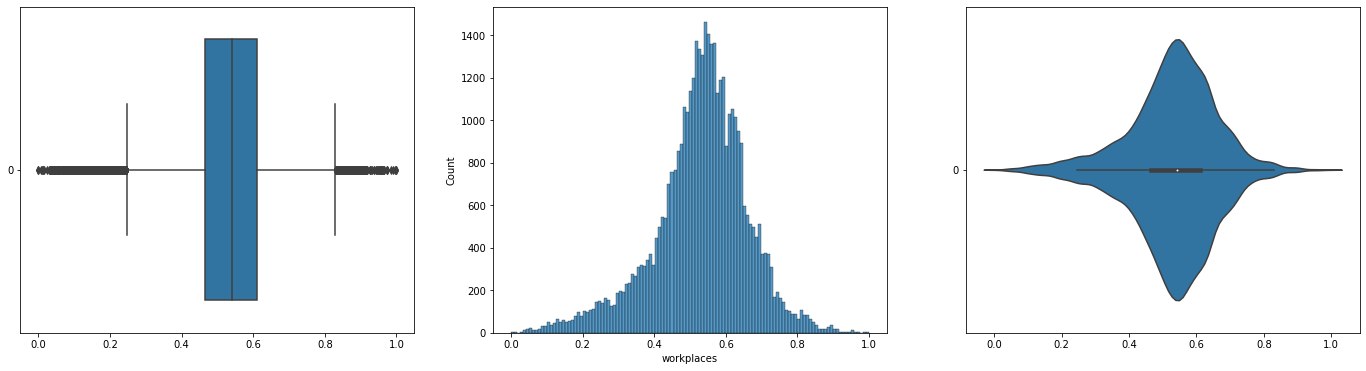

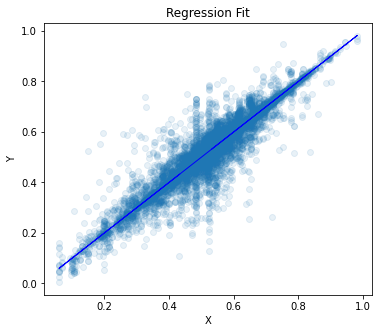

Explained Variance (R^2) 	: 0.8578128079441709
Mean Squared Error (MSE) 	: 0.0023685246925706812
Root-Mean-Squared Error 	: 0.04866749112673347



In [102]:
print("Cluster 1: Decision Tree Regressor\n")
dt_r(cluster1_regression, x_columns, y_columns)

Cluster 2: Decision Tree Regressor

retail_and_recreation


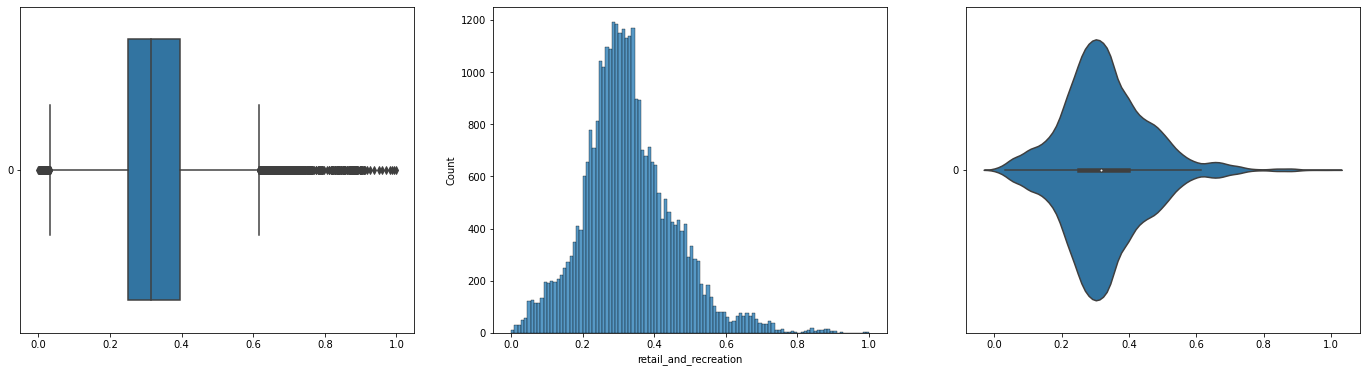

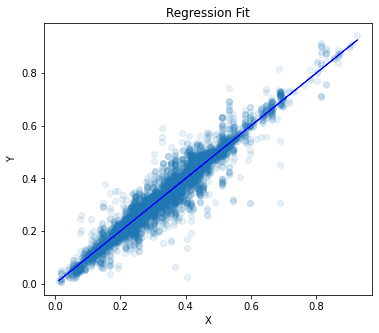

Explained Variance (R^2) 	: 0.9206466015733142
Mean Squared Error (MSE) 	: 0.0012824998582703286
Root-Mean-Squared Error 	: 0.03581200718013902

grocery_and_pharmacy


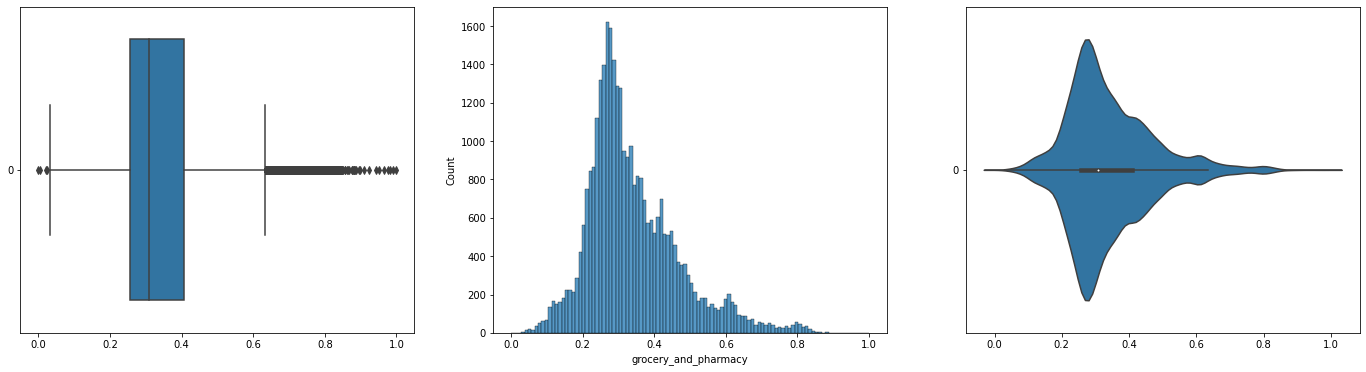

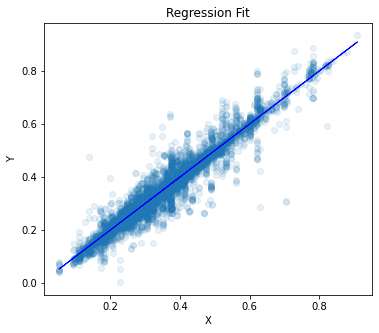

Explained Variance (R^2) 	: 0.9270236697353064
Mean Squared Error (MSE) 	: 0.0012041502787445558
Root-Mean-Squared Error 	: 0.03470086855893604

residential


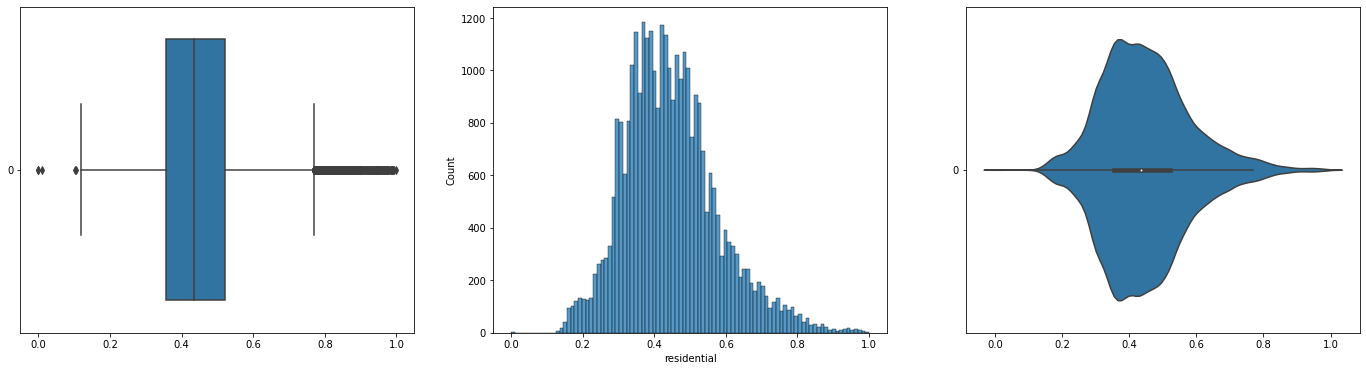

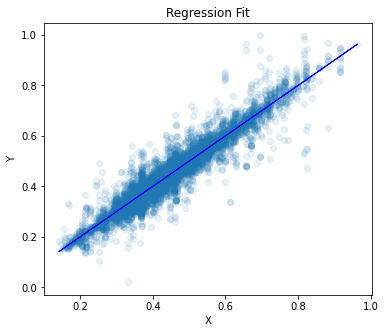

Explained Variance (R^2) 	: 0.9088155598264389
Mean Squared Error (MSE) 	: 0.0015898232567839214
Root-Mean-Squared Error 	: 0.039872587786396824

transit_stations


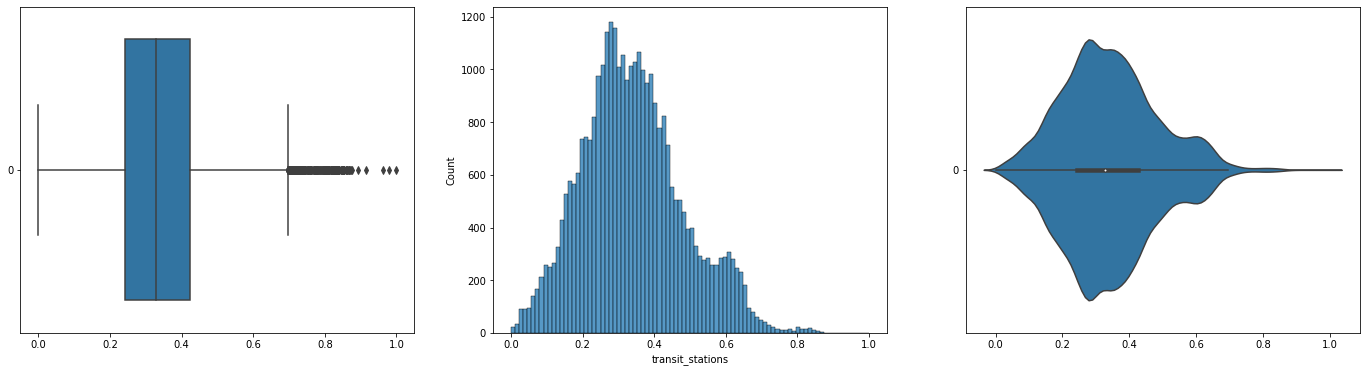

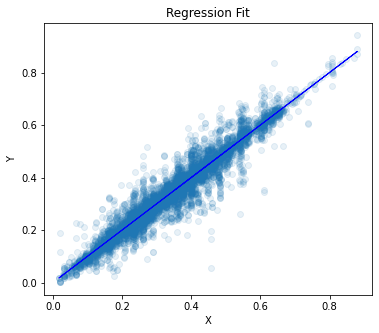

Explained Variance (R^2) 	: 0.9291309552275884
Mean Squared Error (MSE) 	: 0.0014002768170974715
Root-Mean-Squared Error 	: 0.03742027280896642

parks


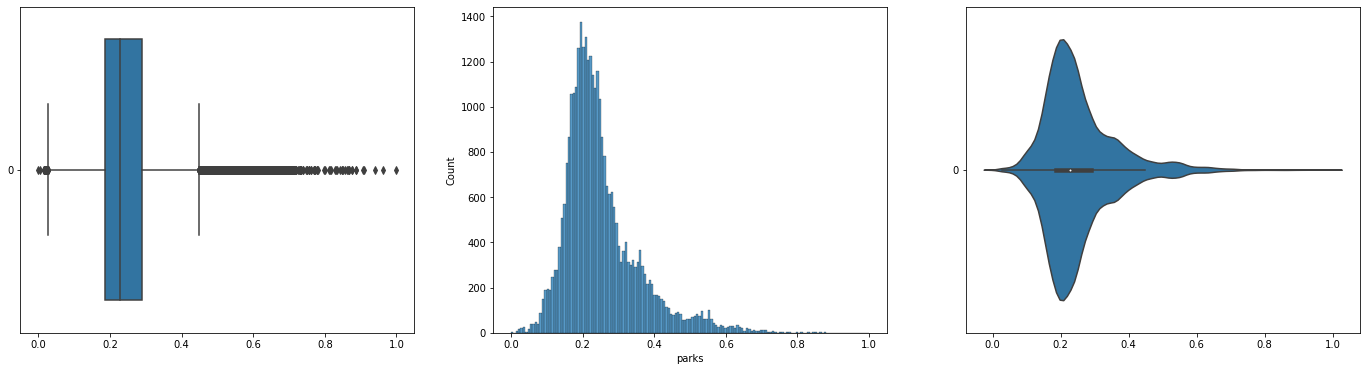

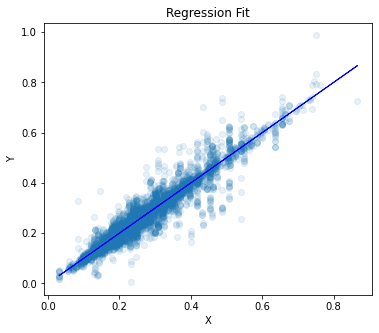

Explained Variance (R^2) 	: 0.9151900693966039
Mean Squared Error (MSE) 	: 0.0009227583110533588
Root-Mean-Squared Error 	: 0.030376937157214498

workplaces


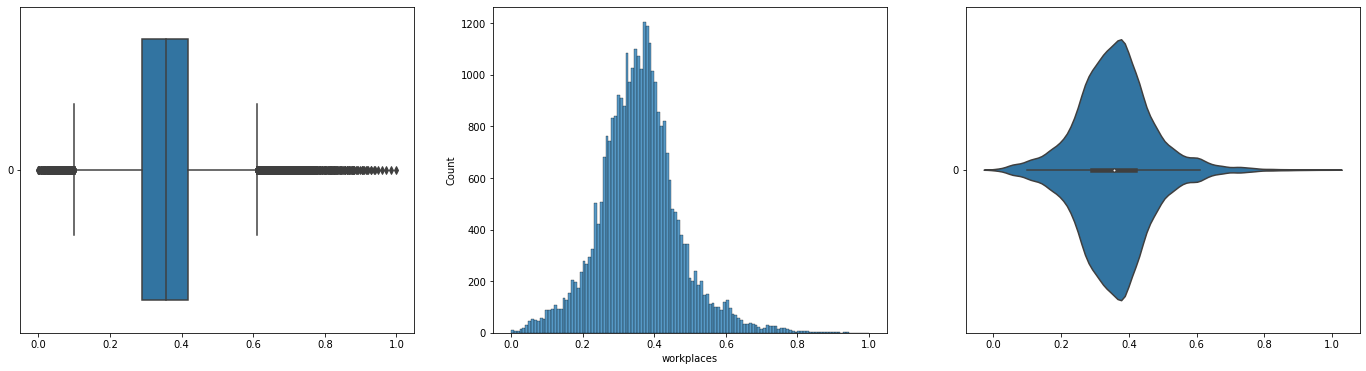

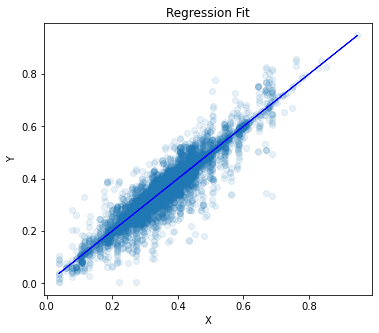

Explained Variance (R^2) 	: 0.8568368165811389
Mean Squared Error (MSE) 	: 0.0017369687394264235
Root-Mean-Squared Error 	: 0.04167695693577476



In [103]:
print("Cluster 2: Decision Tree Regressor\n")
dt_r(cluster2_regression, x_columns, y_columns)

#### Decision Tree Regressor scored the highest among all 3 models with accuracy close to 90%.

### Looking at the results of R2 score for all models, Decision Tree Regressor is the best.
- Best model for cluster 1: Decision Tree Regressor
- Best model for cluster 2: Decision Tree Regressor

# Conclusion
- As the average mobility for each country differs, clustering is needed to group similar country together. The optimal cluster for countries after performing EDA is 2. Developed country and Undeveloped country.
- Mobility among retail, transit station and workplaces has been affected the most during COVID-19. However, for countries in cluster 2, mobility in grocery place have increased drastically instead.
- Both clusters have different influctuation of COVID-19 cases. COVID-19 cases in cluster 1 are mostly stable while cluster 2 spikes frequently. The vaccination rate is also very different for both clusters.
- Mobility in both clusters are affected by different variable hence it crucial to cluster the countries first before performing regression if high accuracy is preferred!
- Prediction of mobility can be done using Decision Tree Regressor model and the accuracy is at least 90% for both clusters!
